In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.svm import SVR
from ForecastSimulator2 import Forecastsimulator, forecast_split
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.ensemble import BaggingRegressor

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from pandas_datareader import data as web

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.grid'] = True

In [2]:
today = date.today()
start_date = today - relativedelta(years=4)

print(start_date)
data = pd.DataFrame(web.DataReader('MERC', 'stooq', start_date))
data.info()

2019-03-19
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2023-03-17 to 2019-03-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1008 non-null   float64
 1   High    1008 non-null   float64
 2   Low     1008 non-null   float64
 3   Close   1008 non-null   float64
 4   Volume  1008 non-null   float64
dtypes: float64(5)
memory usage: 47.2 KB


In [3]:
unicredit = data[['Close']]
unicredit = unicredit.sort_index(ascending = True)
unicredit

,Close
Date,
2019-03-19,12.1685
2019-03-20,12.1844
2019-03-21,12.4788
2019-03-22,12.0026
2019-03-25,12.0263
...,...
2023-03-13,10.1300
2023-03-14,10.1500
2023-03-15,9.8400


<Axes: xlabel='Date'>

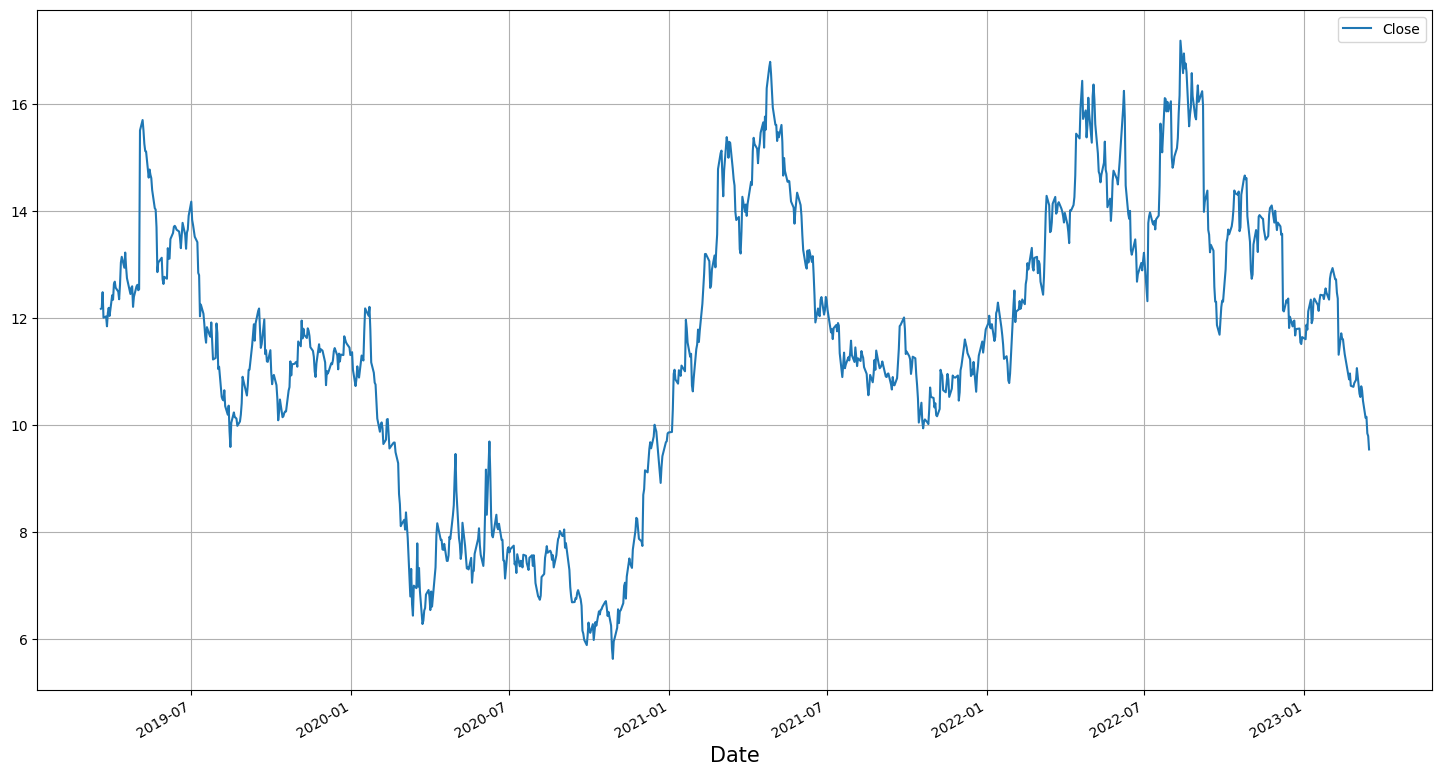

In [4]:
unicredit.plot()

In [5]:
def cnn_lstm(ws=30, dtp=1, multi=5):
    
    model = tf.keras.Sequential()

    # Creating the Neural Network model
    # CNN layers
    model.add(TimeDistributed(Conv1D(256, kernel_size=5, padding='same', activation='selu', input_shape=(None, ws, 1))))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))

    # LSTM layers
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=True)))
    model.add(Dense(5, kernel_regularizer=L2(0.5)))
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=False)))
    model.add(Dense(5, kernel_regularizer=L2(0.5)))

    #Final layers
    model.add(Dense(dtp, activation='linear'))
    model.compile(optimizer='Adamax', loss='mse', metrics=['mse', 'mae', 'mape'])

    return model

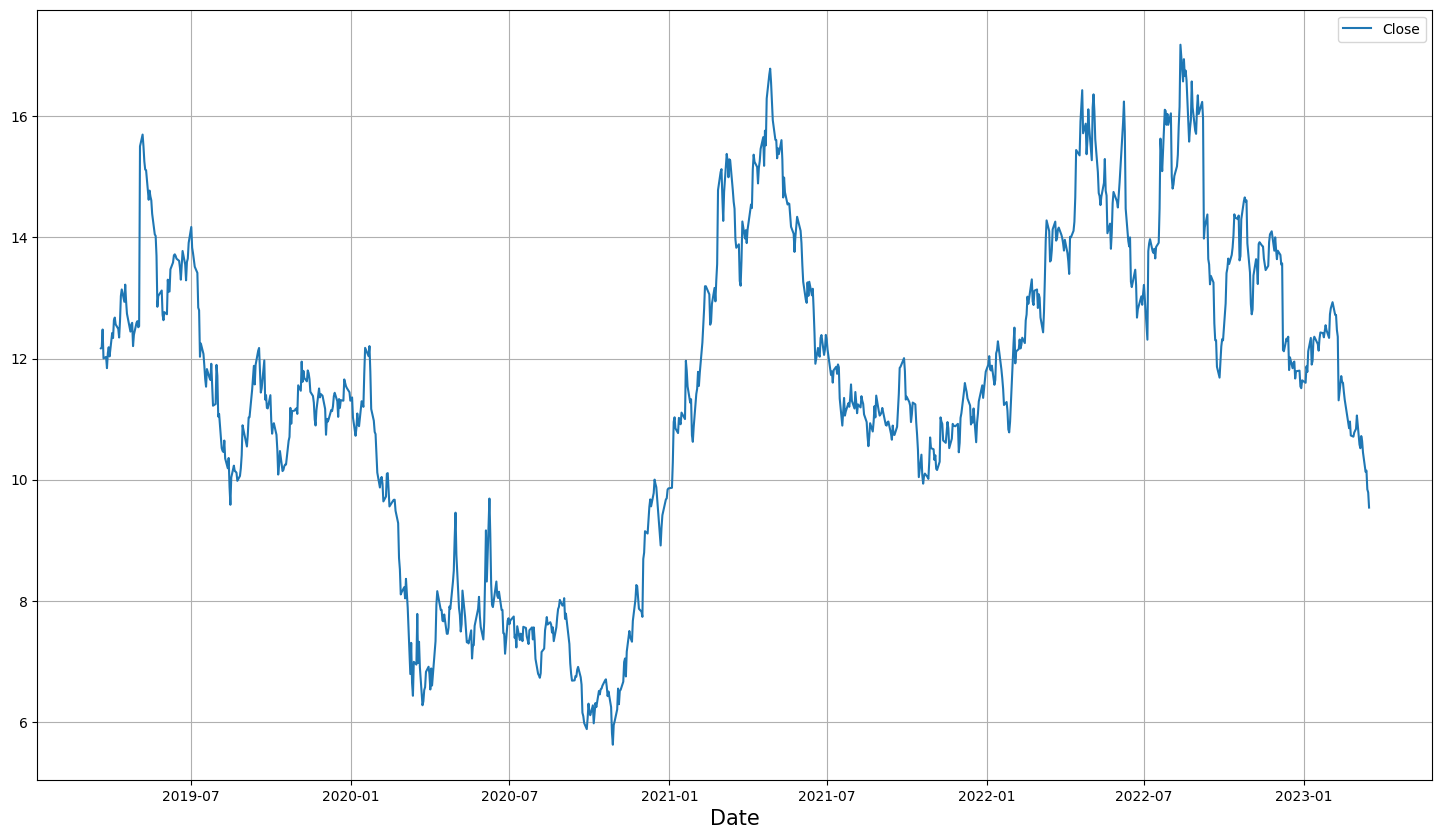

Epoch 1/100
37/37 - 6s - loss: 8.9175 - mse: 0.4937 - mae: 0.5298 - mape: 210.5794 - 6s/epoch - 164ms/step
Epoch 2/100
37/37 - 0s - loss: 6.2922 - mse: 0.2210 - mae: 0.3537 - mape: 404.5524 - 204ms/epoch - 6ms/step
Epoch 3/100
37/37 - 0s - loss: 4.5730 - mse: 0.1891 - mae: 0.3230 - mape: 385.2322 - 170ms/epoch - 5ms/step
Epoch 4/100
37/37 - 0s - loss: 3.3521 - mse: 0.1688 - mae: 0.3022 - mape: 318.4099 - 143ms/epoch - 4ms/step
Epoch 5/100
37/37 - 0s - loss: 2.4799 - mse: 0.1520 - mae: 0.2787 - mape: 285.6625 - 143ms/epoch - 4ms/step
Epoch 6/100
37/37 - 0s - loss: 1.8554 - mse: 0.1371 - mae: 0.2589 - mape: 242.8079 - 143ms/epoch - 4ms/step
Epoch 7/100
37/37 - 0s - loss: 1.4065 - mse: 0.1225 - mae: 0.2404 - mape: 173.8476 - 174ms/epoch - 5ms/step
Epoch 8/100
37/37 - 0s - loss: 1.0866 - mse: 0.1178 - mae: 0.2332 - mape: 173.8273 - 189ms/epoch - 5ms/step
Epoch 9/100
37/37 - 0s - loss: 0.8584 - mse: 0.1074 - mae: 0.2206 - mape: 168.1900 - 193ms/epoch - 5ms/step
Epoch 10/100
37/37 - 0s - los

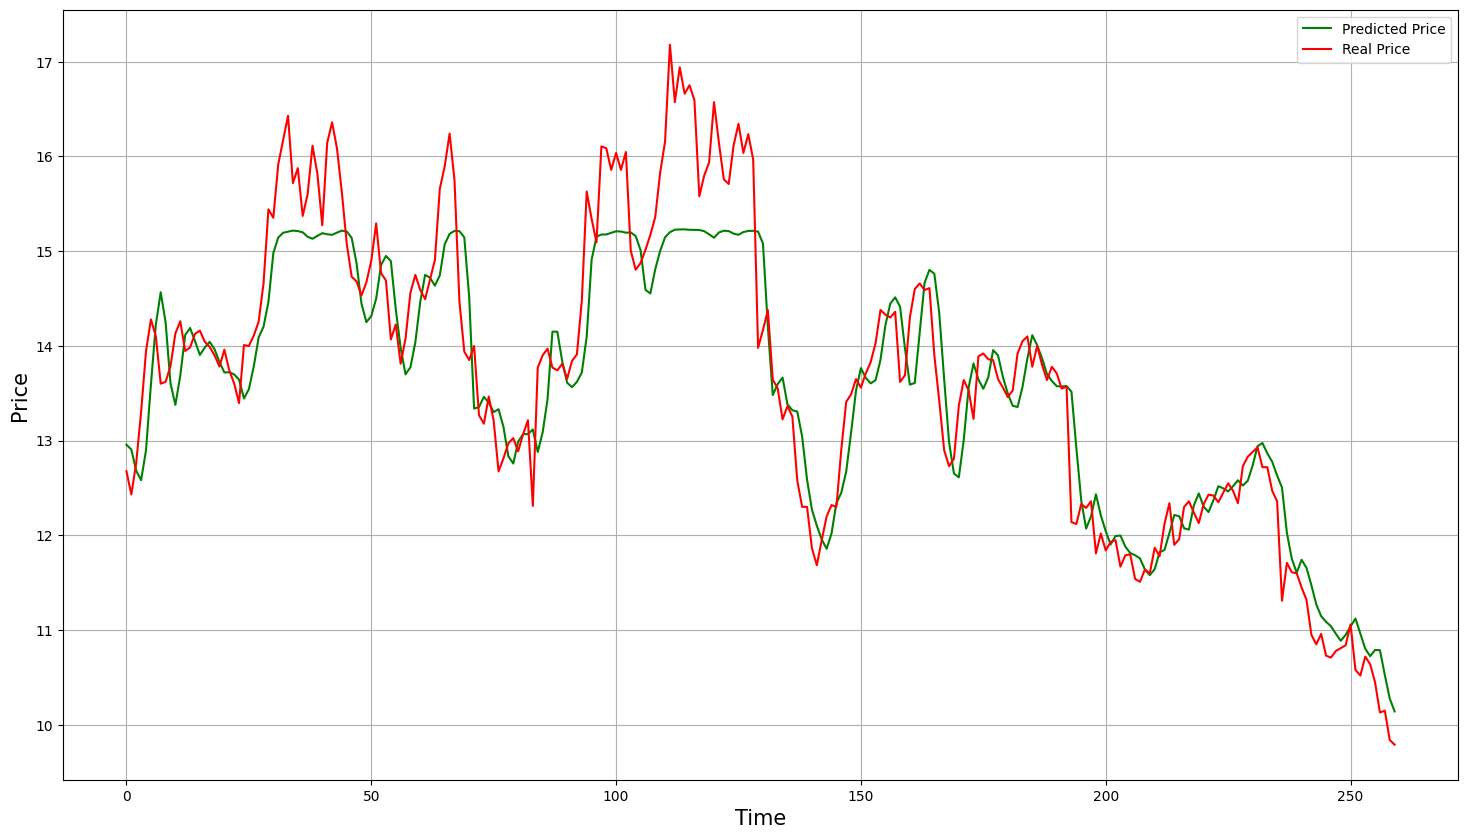

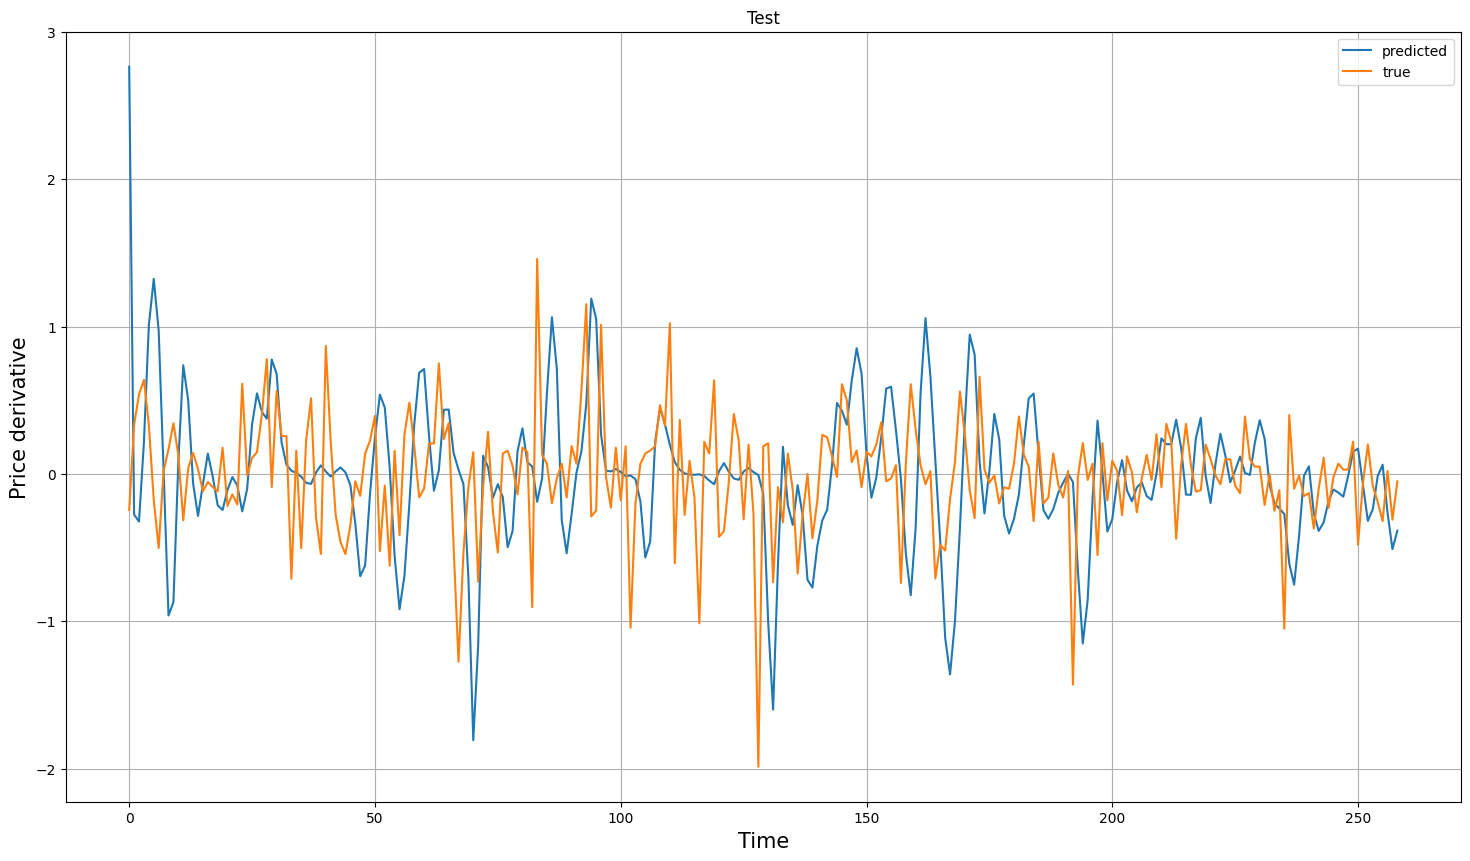

0.4806201550387597


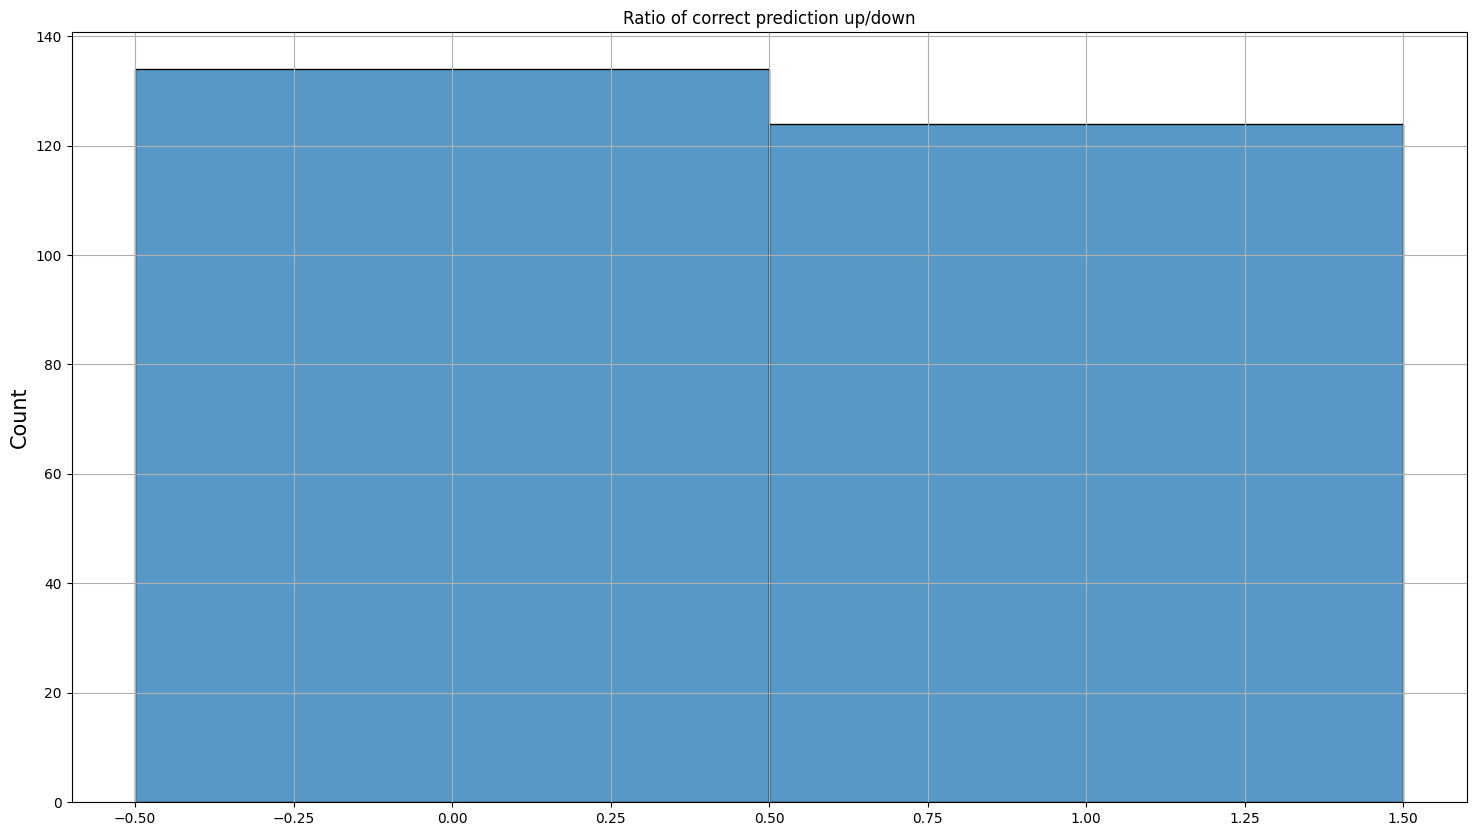

0.13273068531795384 2.746058339056345


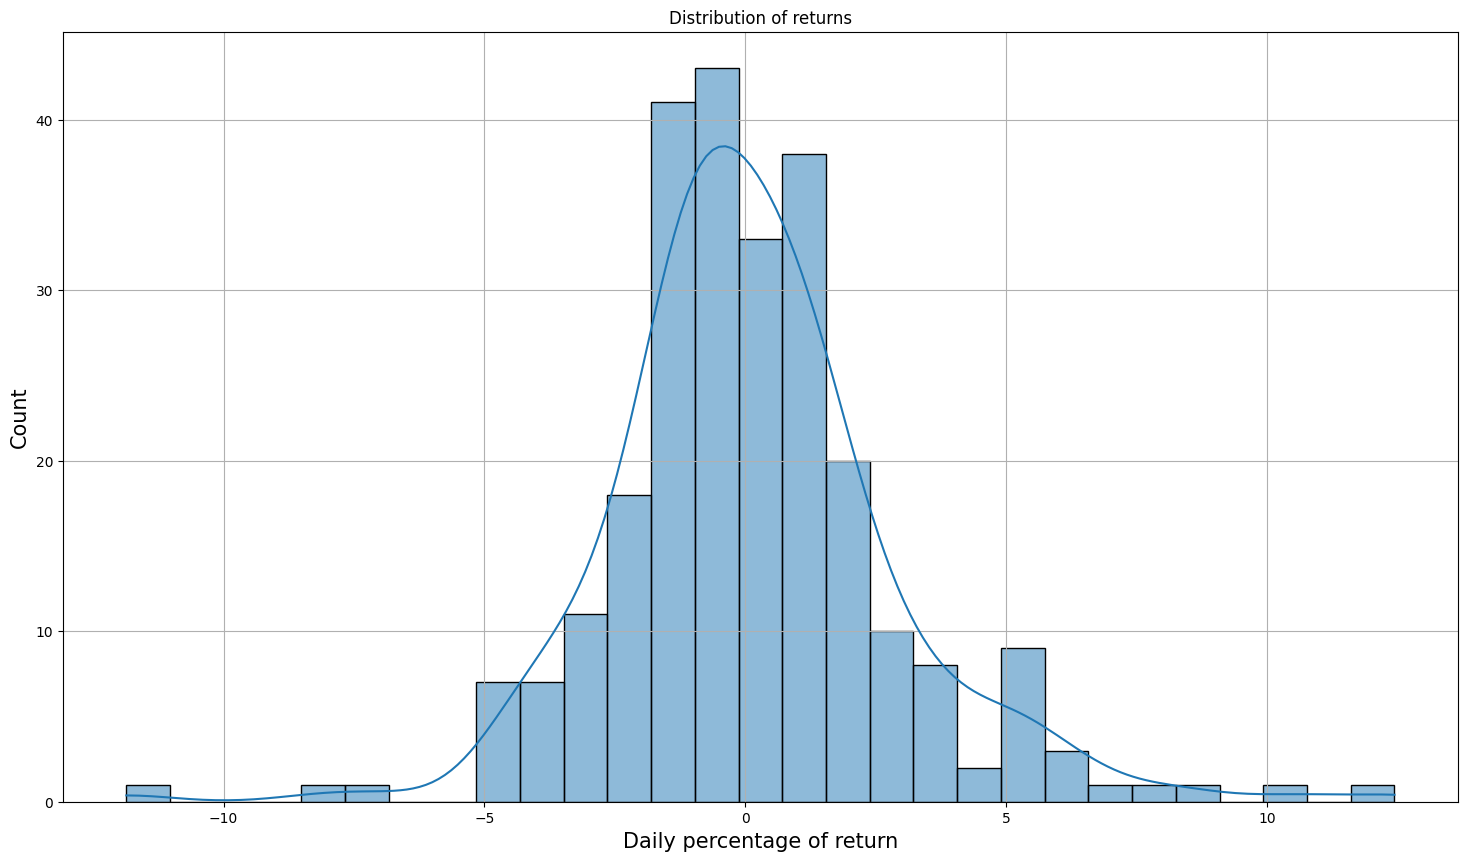

171.22258406016044


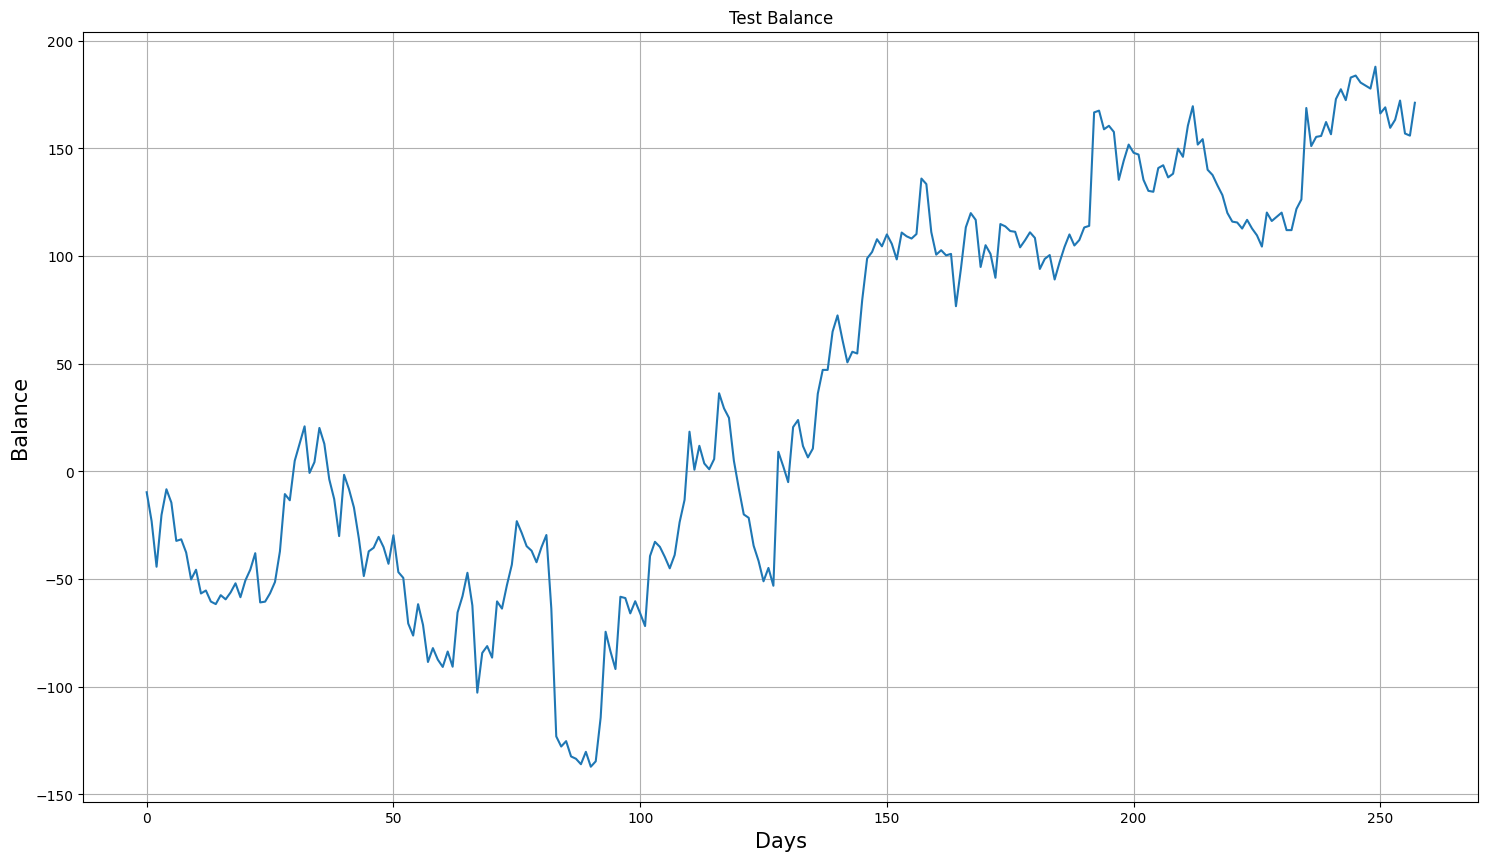

In [6]:
ws = 10
dtp = 1
sns.lineplot(unicredit)
plt.show()

X_train, X_test, y_train, y_test, y_val = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=260)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)
    
fs = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp, multi=3))
fs.train_nn(X_train_reshaped, y_train_scaled, epochs=100, batch_size=20)
prediction = scaler_y.inverse_transform(fs.predict(X_test_reshaped))

fs.plot_prediction(prediction, y_val)
fs.simulate(prediction, y_val)
del fs

0
1/1 [==============================] - 1s 1s/step
1
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 23ms/step
3
1/1 [==============================] - 0s 20ms/step
4
1/1 [==============================] - 0s 27ms/step
5
1/1 [==============================] - 0s 18ms/step
6
1/1 [==============================] - 0s 17ms/step
7
1/1 [==============================] - 0s 17ms/step
8
1/1 [==============================] - 0s 18ms/step
9
1/1 [==============================] - 0s 19ms/step
10
1/1 [==============================] - 0s 20ms/step
11
1/1 [==============================] - 0s 22ms/step
12
1/1 [==============================] - 0s 21ms/step
13
1/1 [==============================] - 0s 24ms/step
14
1/1 [==============================] - 0s 22ms/step
15
1/1 [==============================] - 0s 22ms/step
16
1/1 [==============================] - 0s 27ms/step
17
1/1 [==============================] - 0s 22ms/step
18
1/1 [==============

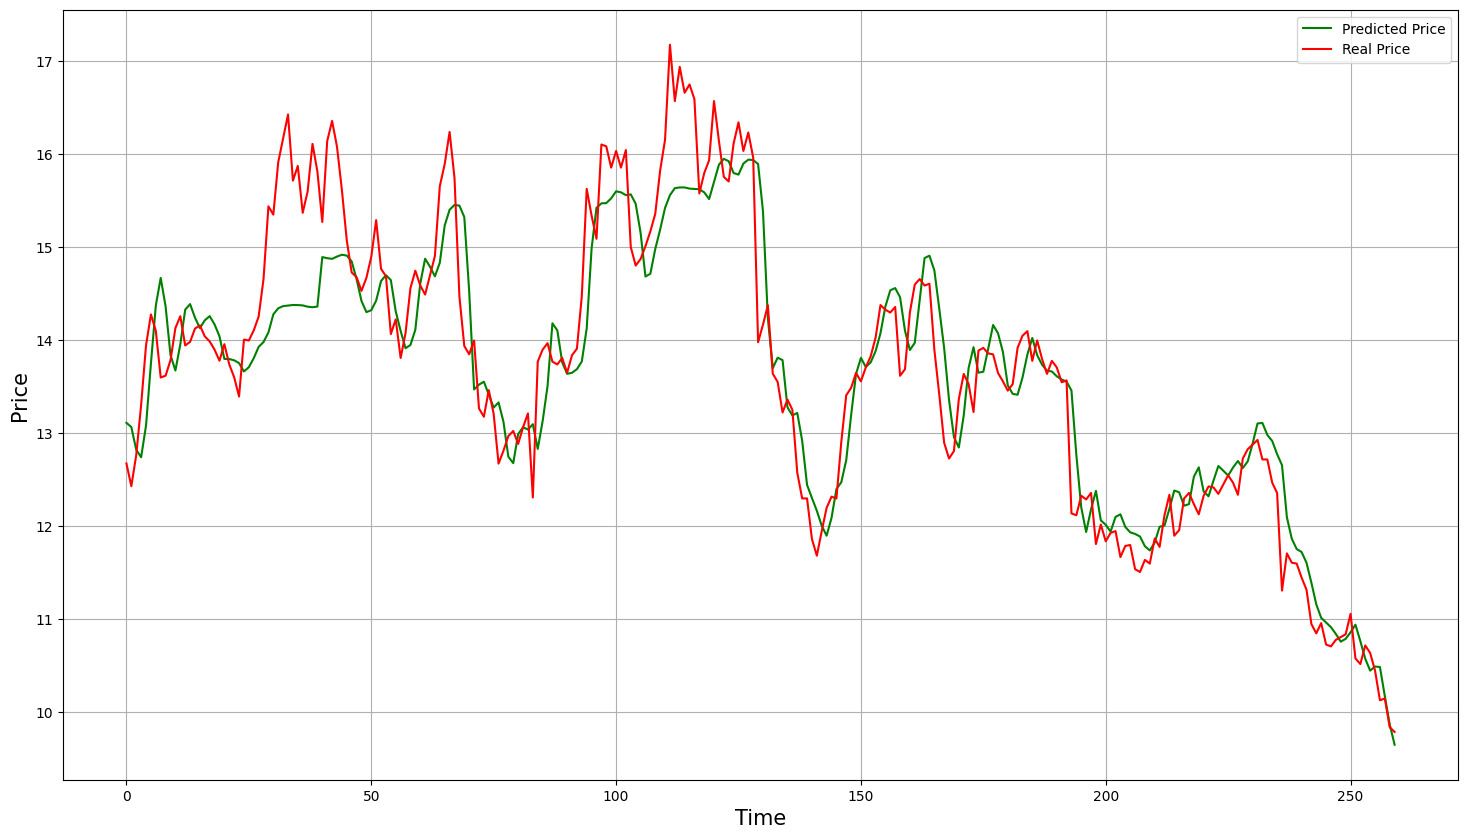

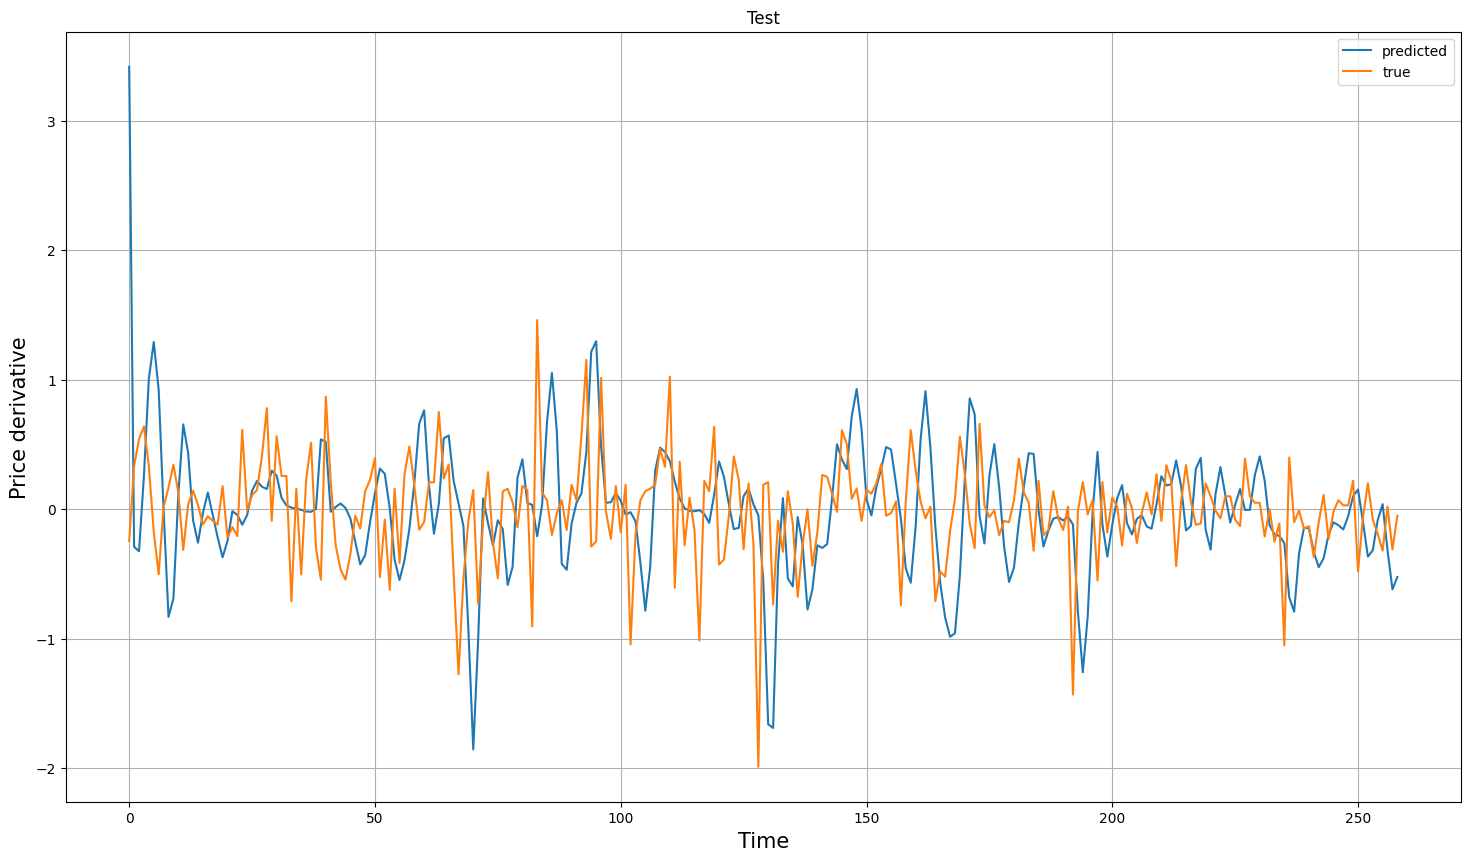

0.47674418604651164


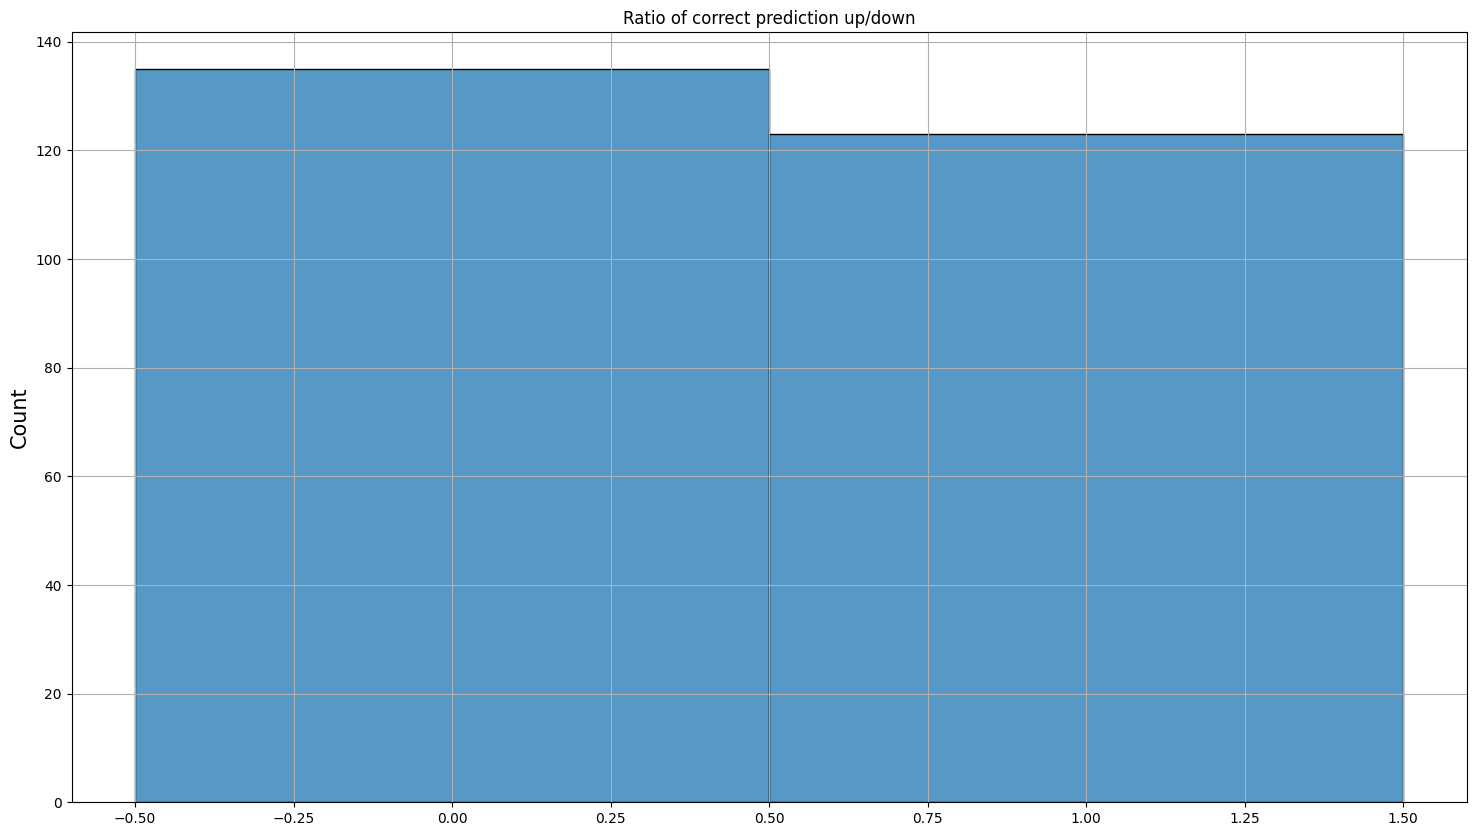

0.12146552955612627 2.7465796841627435


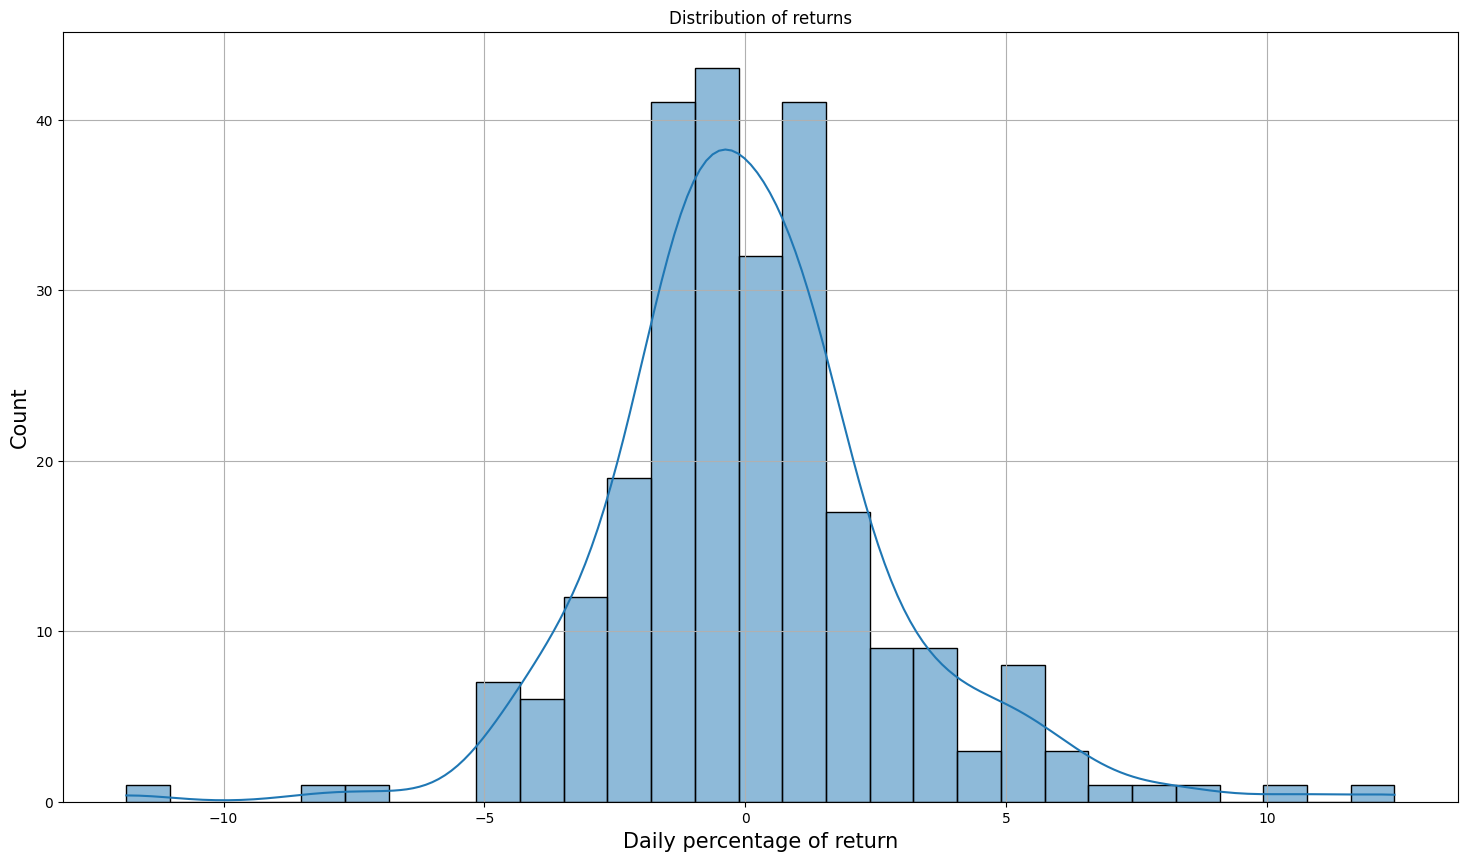

156.6905331274029


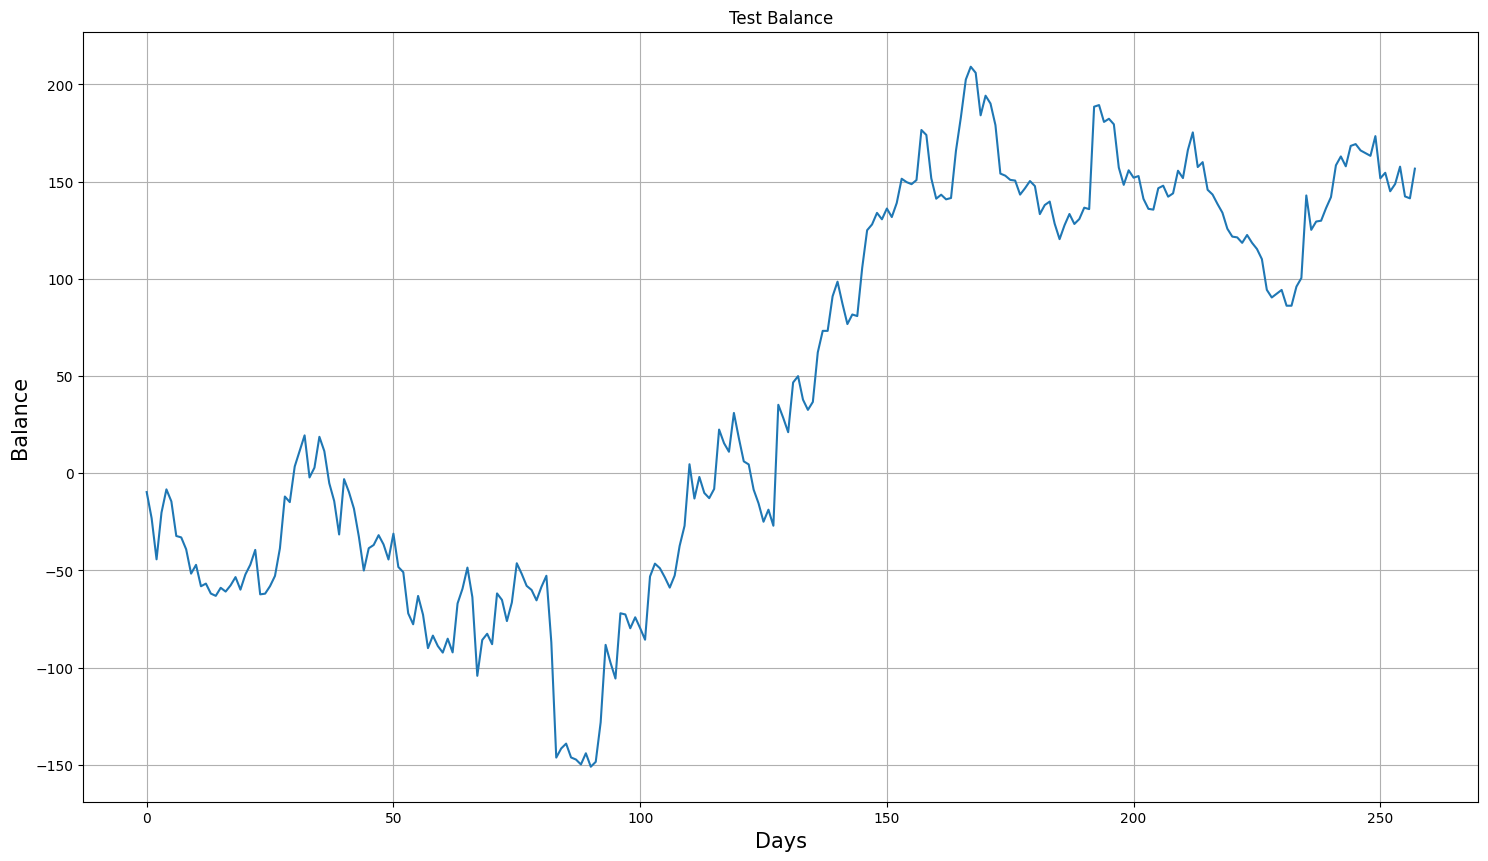

In [7]:
dtp=1

X_train, X_test, y_train, y_test, y_val = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=260)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)

fs2 = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp))
pred = fs2.retrain_nn(cnn_lstm(ws=ws, dtp=dtp), X_train_reshaped, X_test_reshaped, y_train_scaled, y_test_scaled, retrain_period=20)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_val)
fs2.simulate(prediction, y_val)

# XGBoost

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259


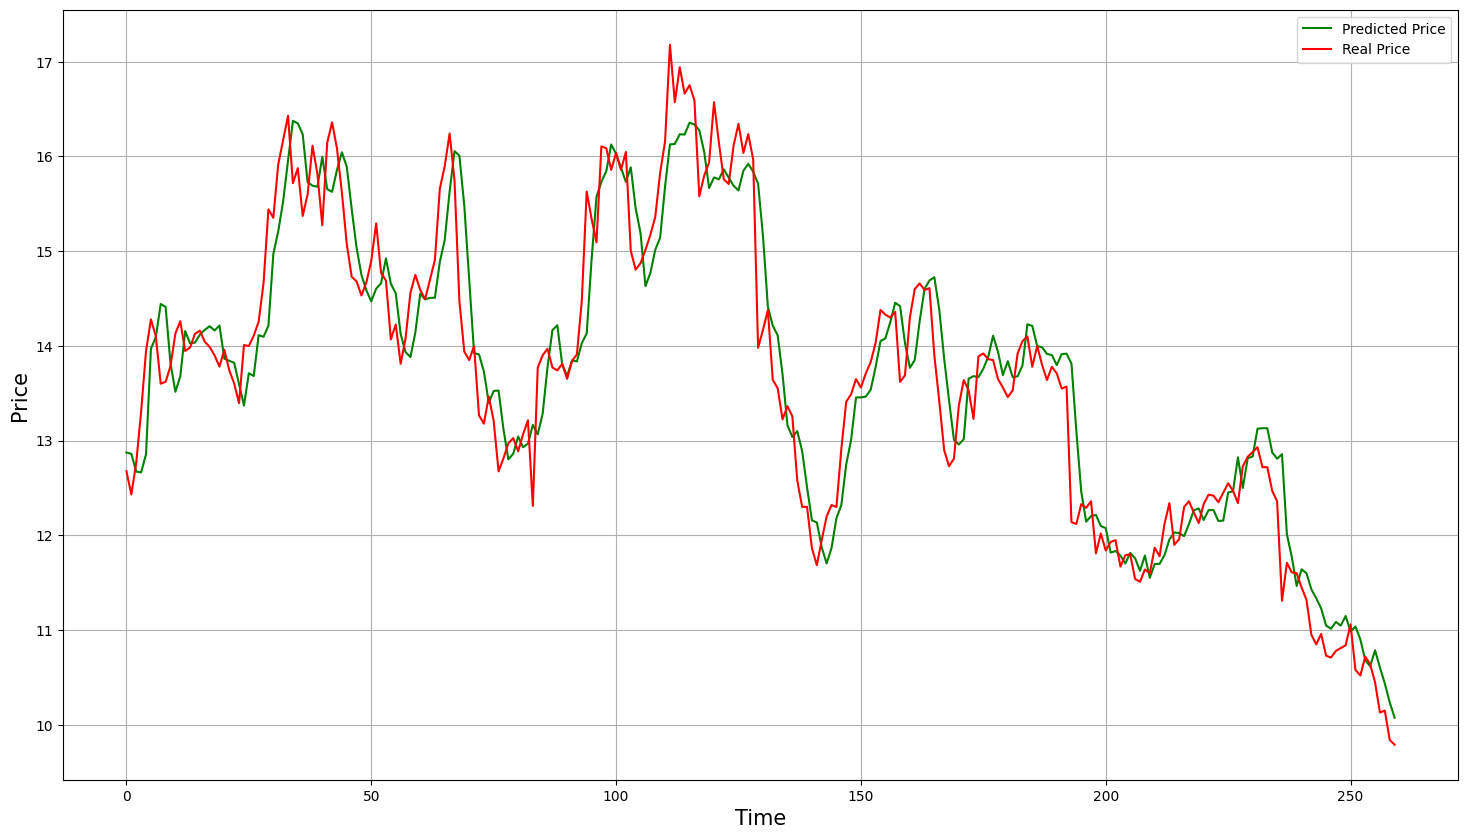

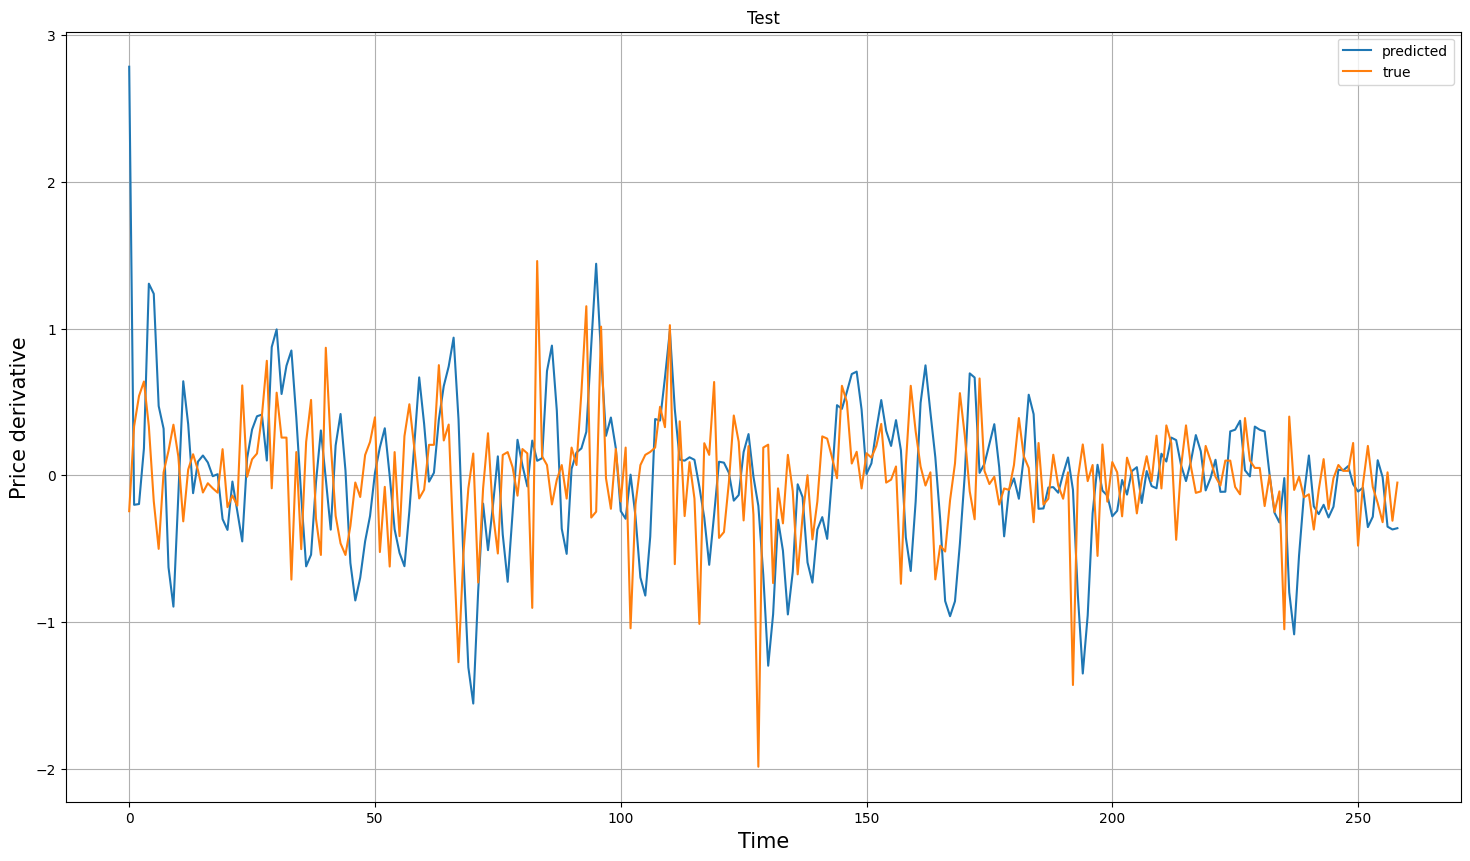

0.49612403100775193


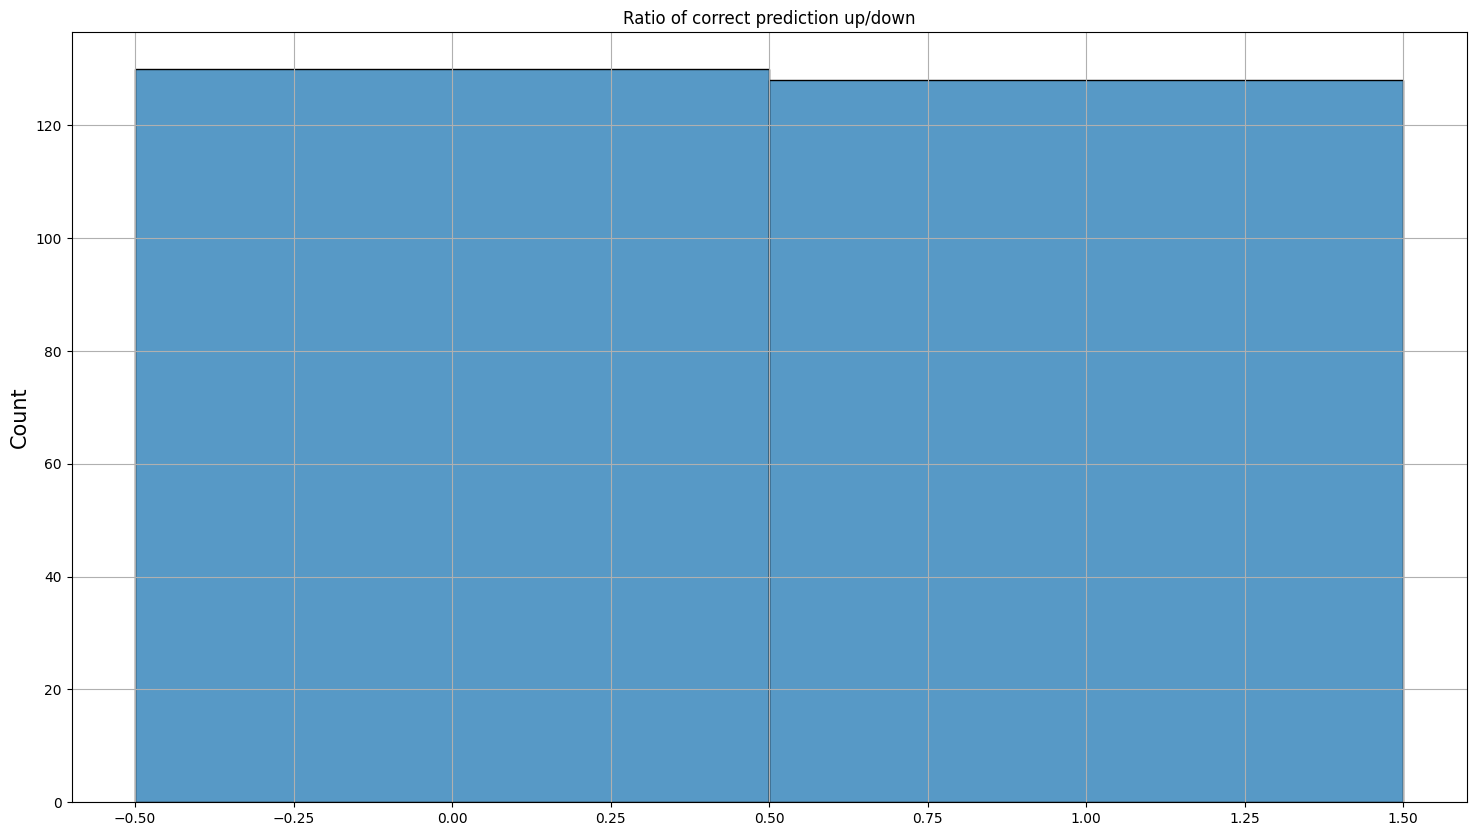

0.13620557501287625 2.7458881764670022


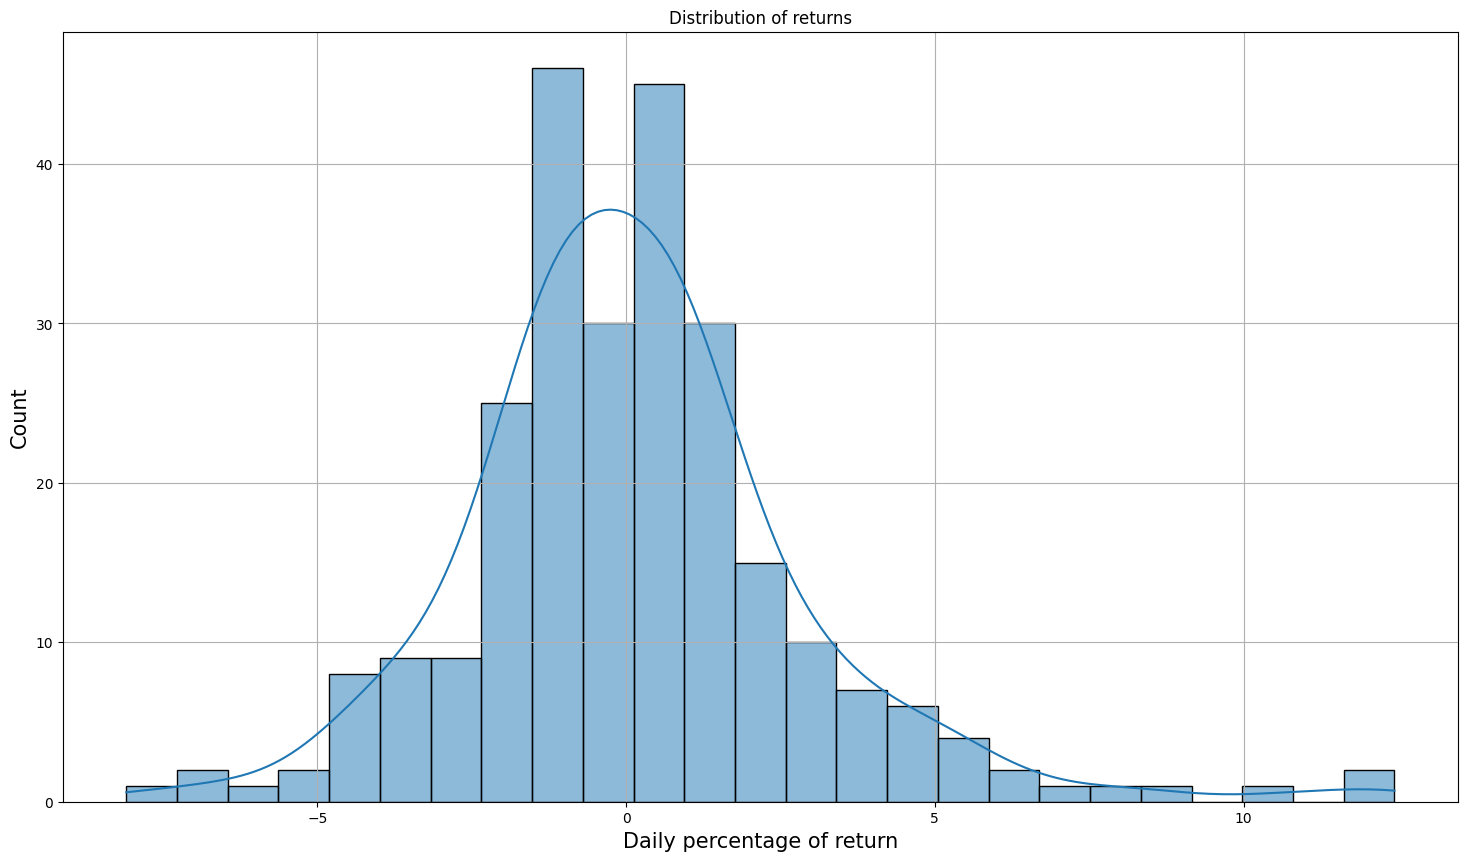

175.70519176661037


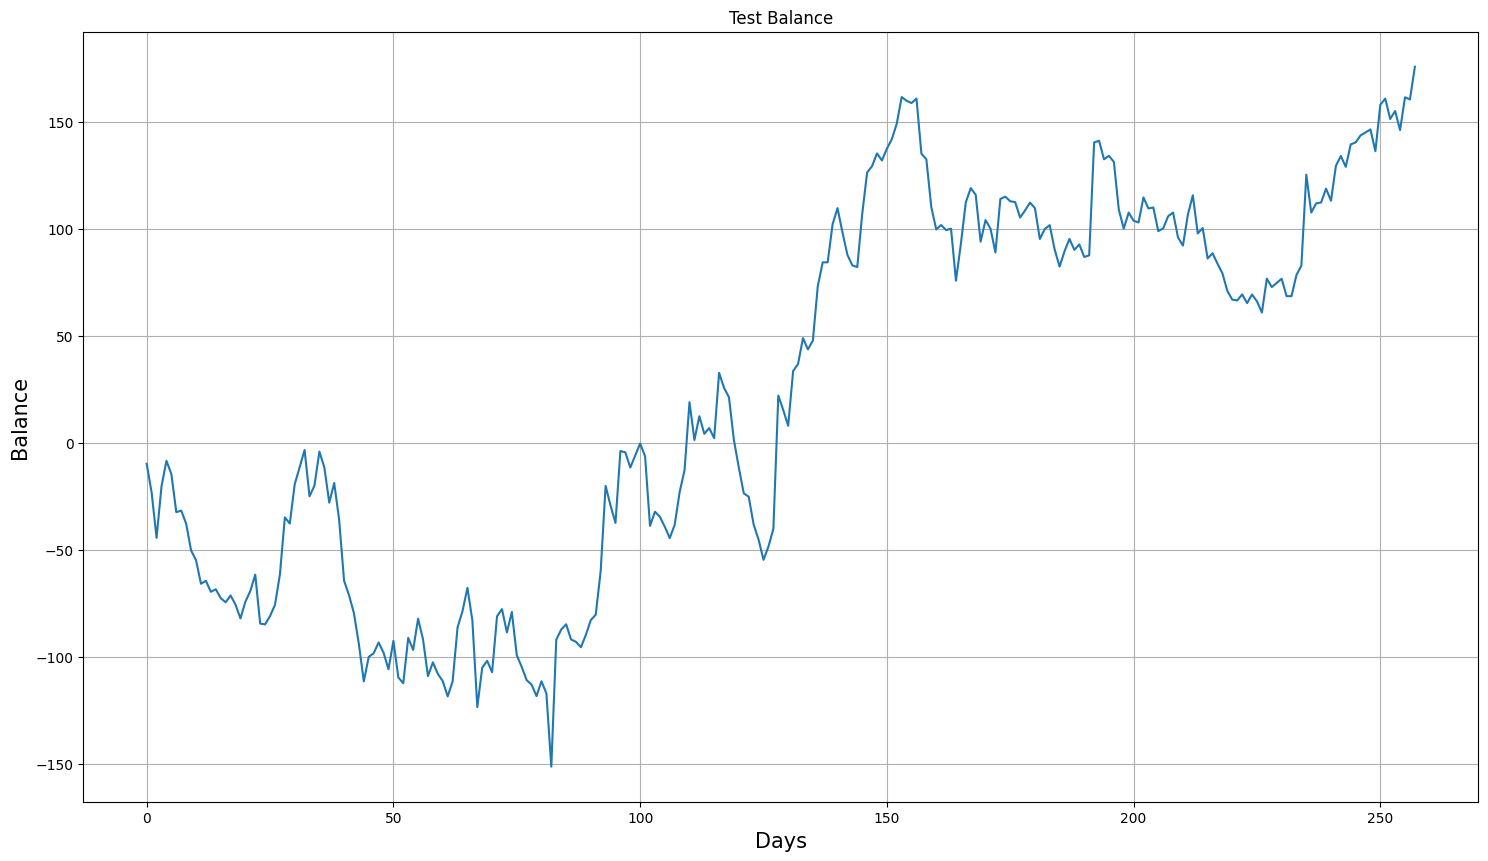

In [8]:
dtp=1
ws=10

X_train, X_test, y_train, y_test, y_val = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=260)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

fs2 = Forecastsimulator(XGBRegressor())
pred = fs2.retrain(XGBRegressor(), X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, retrain_period=20)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_val)
fs2.simulate(prediction, y_val)

# Bayesian Ridge

c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A col

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A col

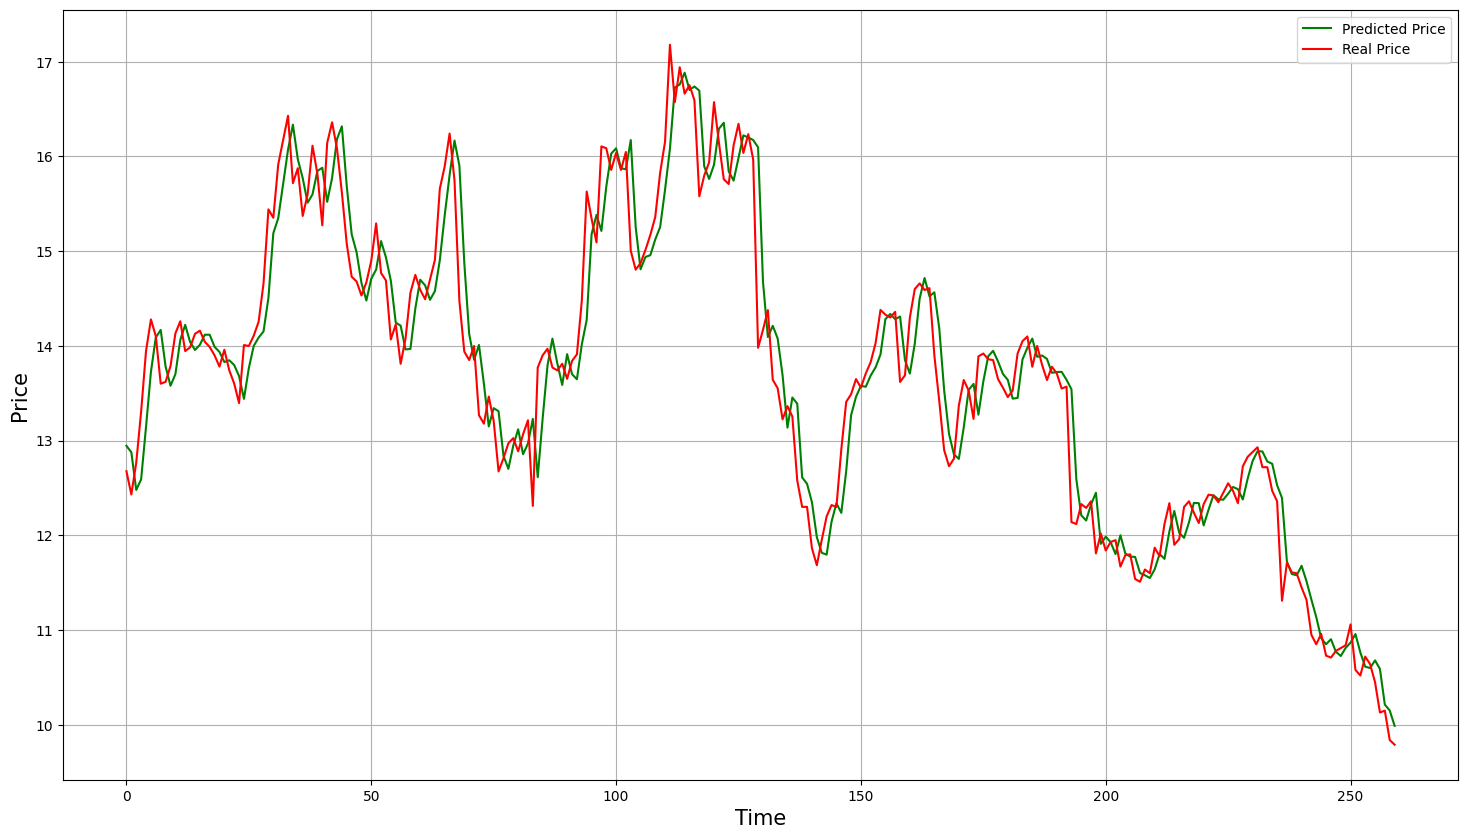

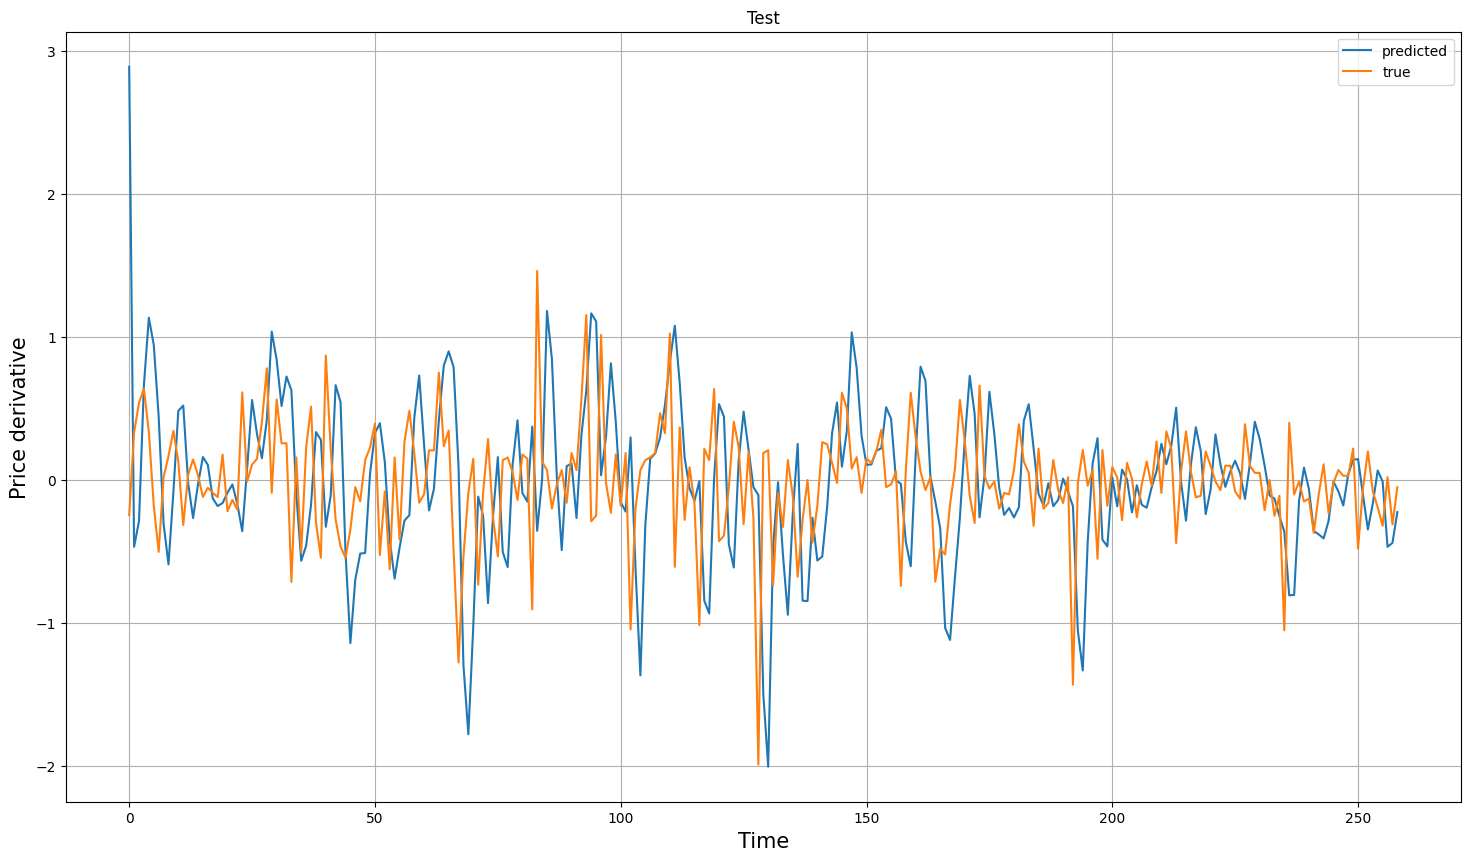

0.49224806201550386


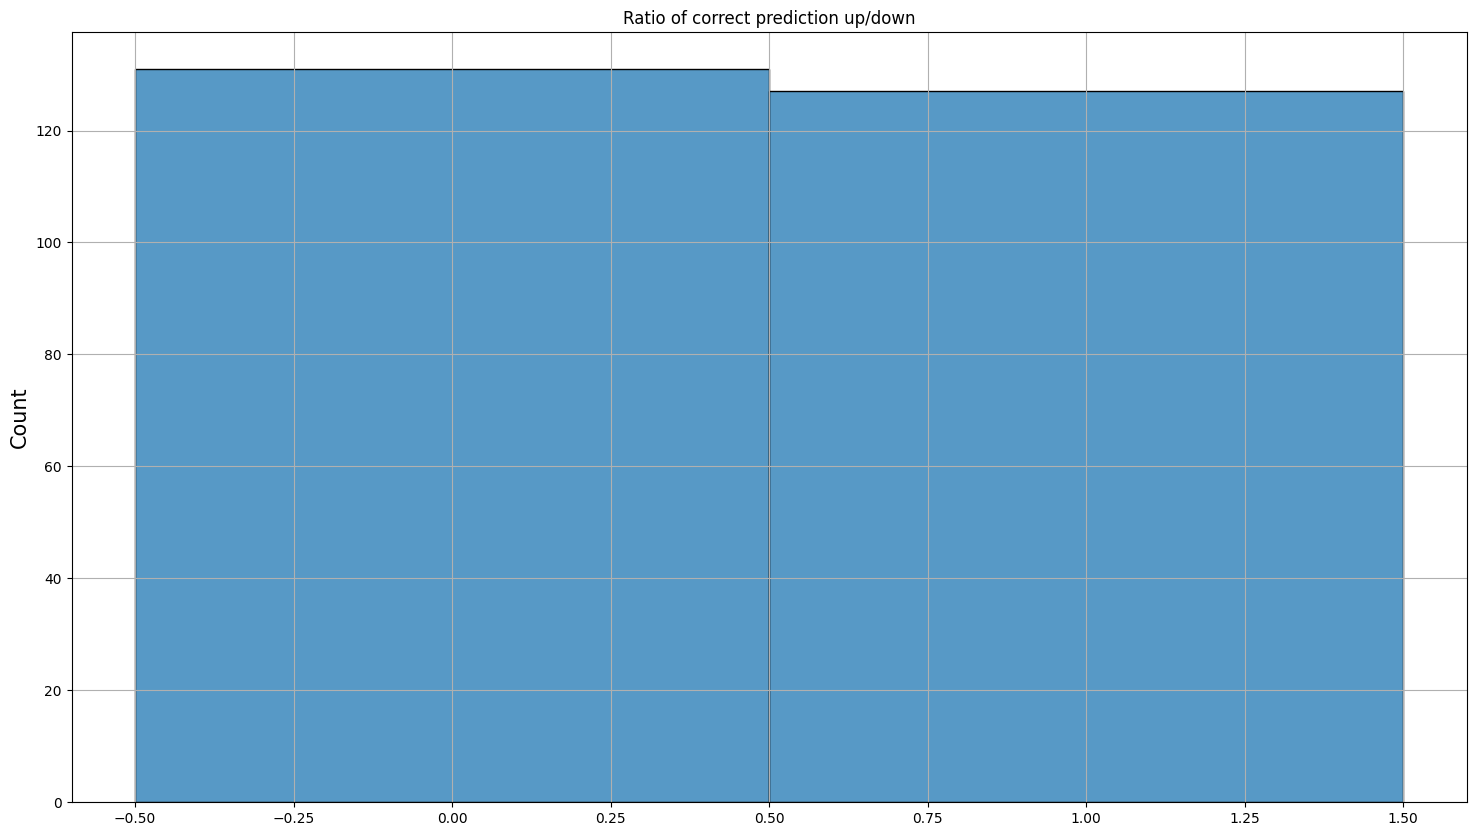

0.09709046862553805 2.747549322073753


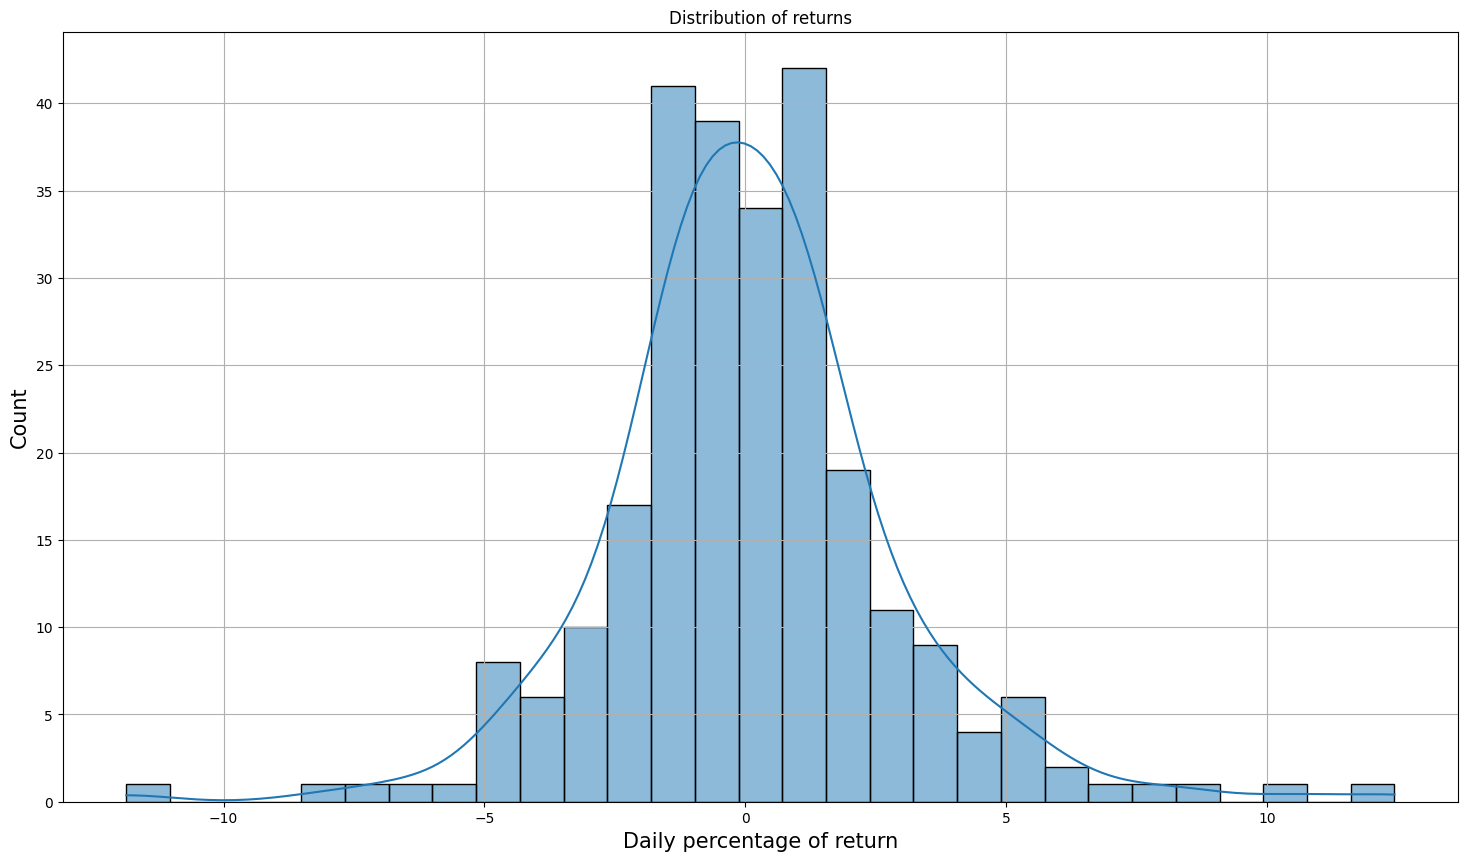

125.24670452694409


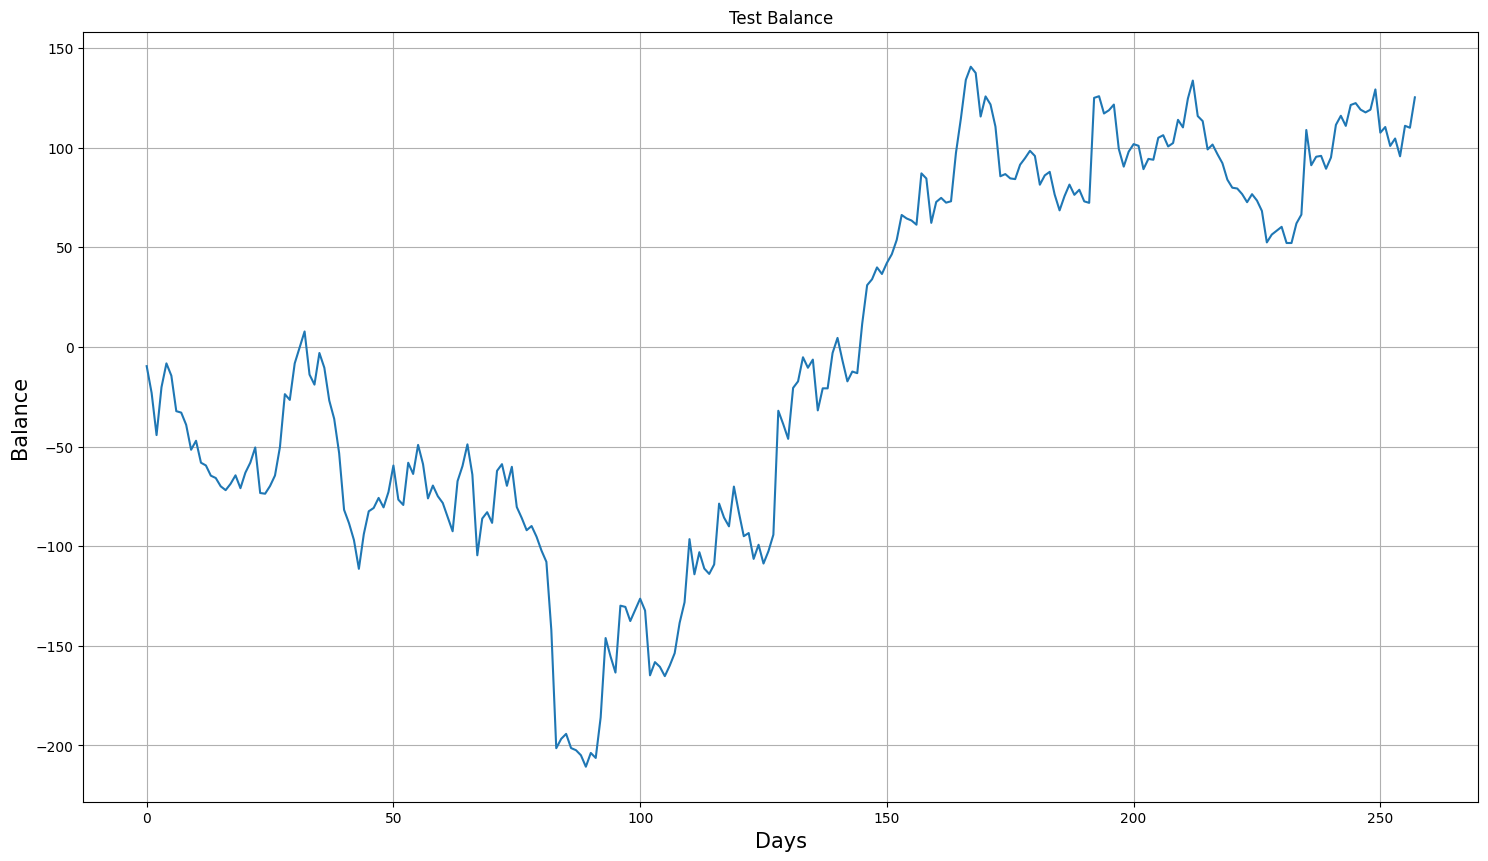

In [9]:
dtp=1

X_train, X_test, y_train, y_test, y_val = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=260)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

fs2 = Forecastsimulator(BaggingRegressor(BayesianRidge()))
pred = fs2.retrain(BaggingRegressor(BayesianRidge(lambda_2=0.1), 10), X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, retrain_period=20)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_val)
fs2.simulate(prediction, y_val)

# SVR

c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


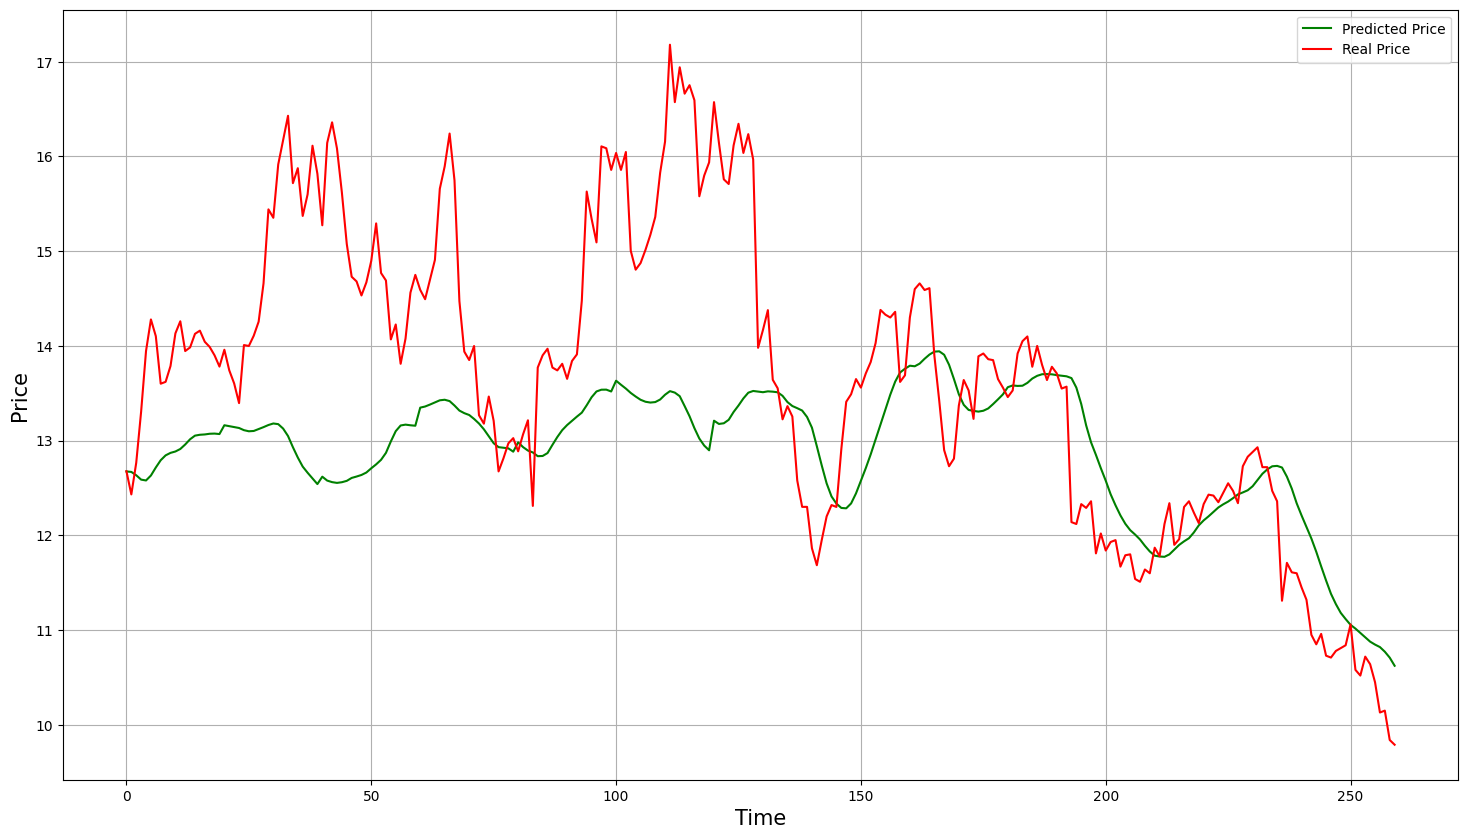

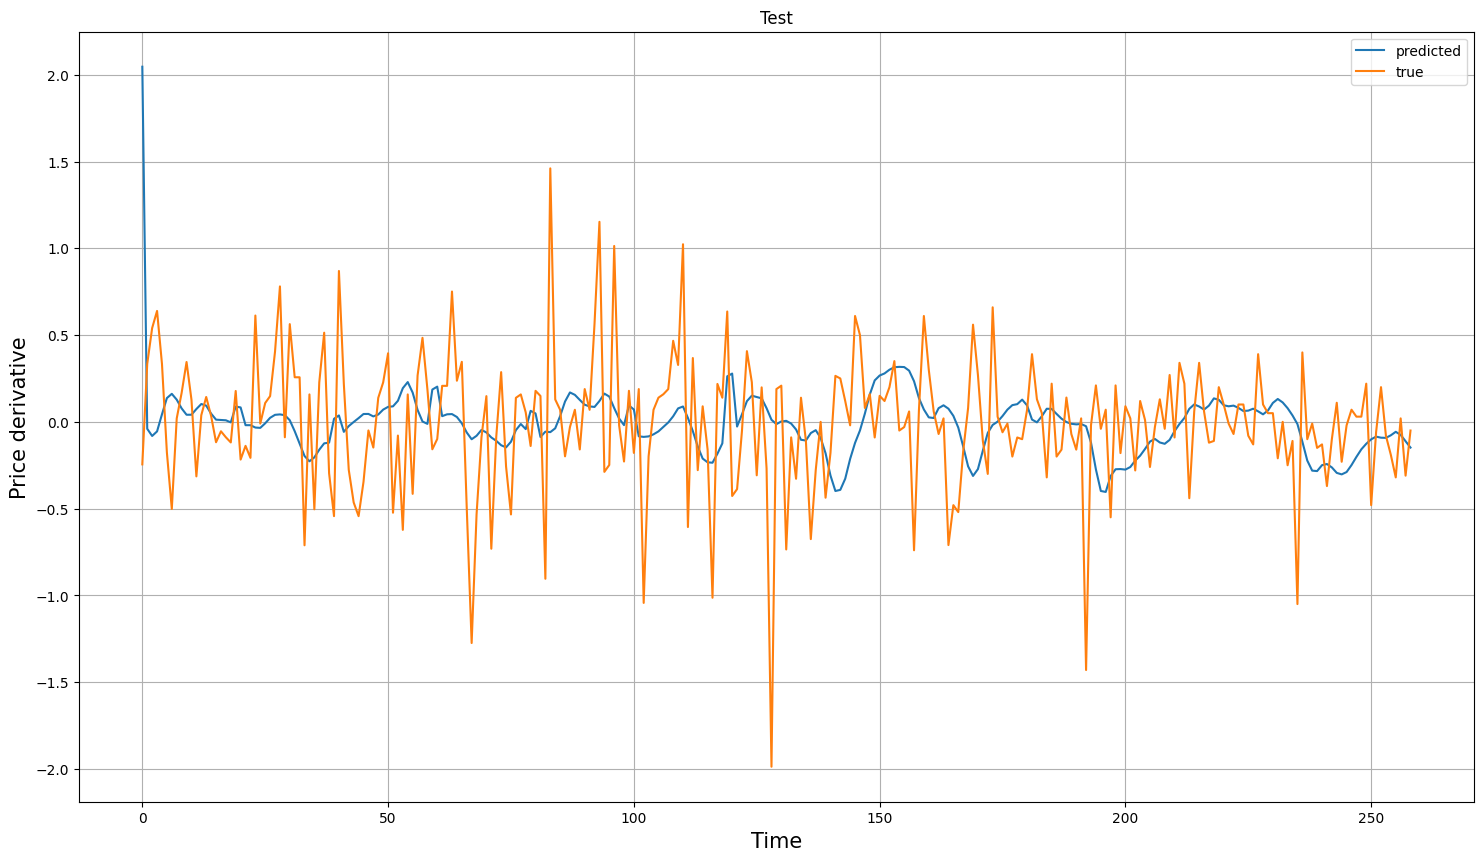

0.5232558139534884


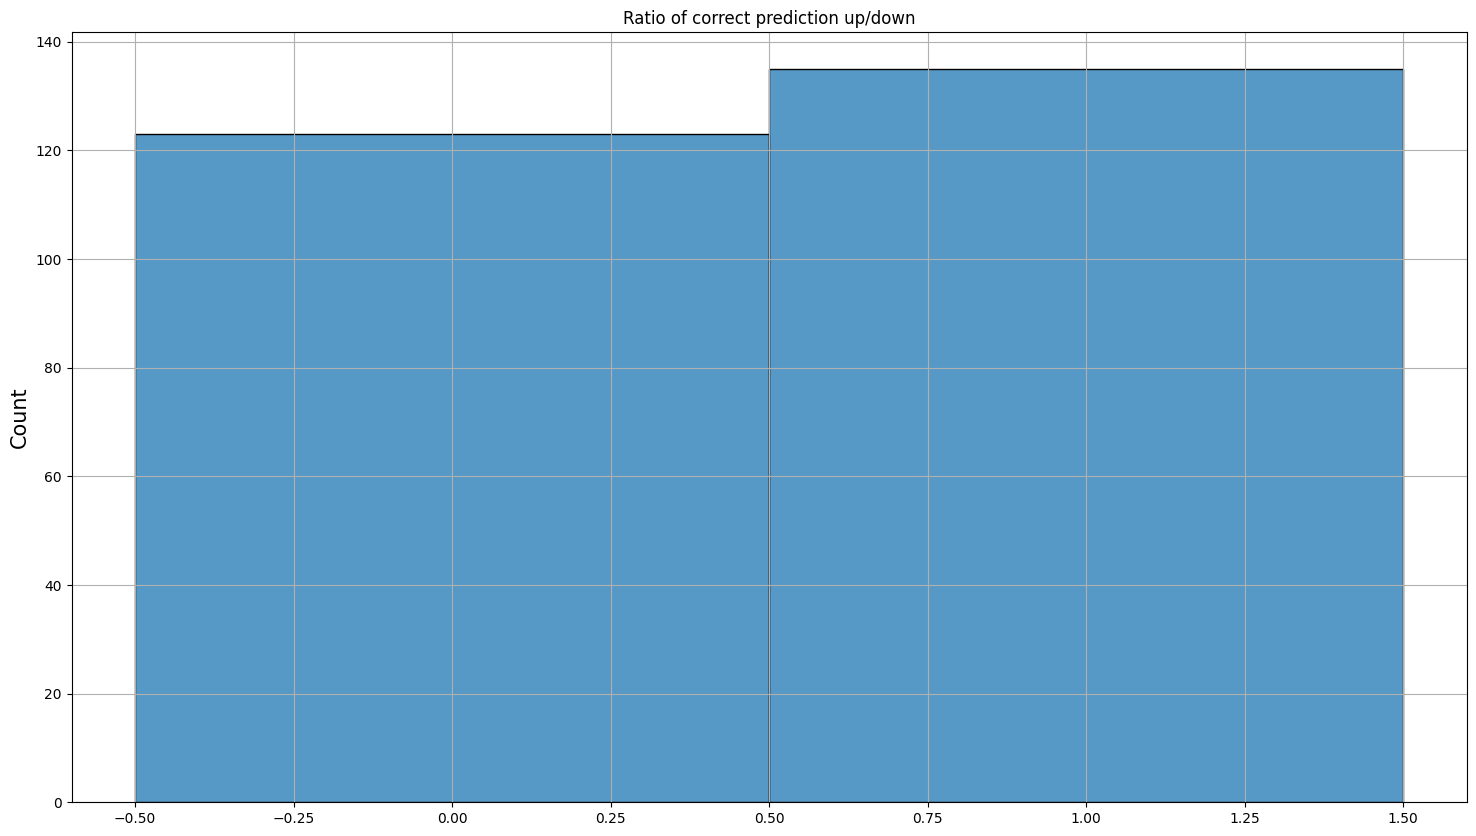

0.24360779006405942 2.738450123874081


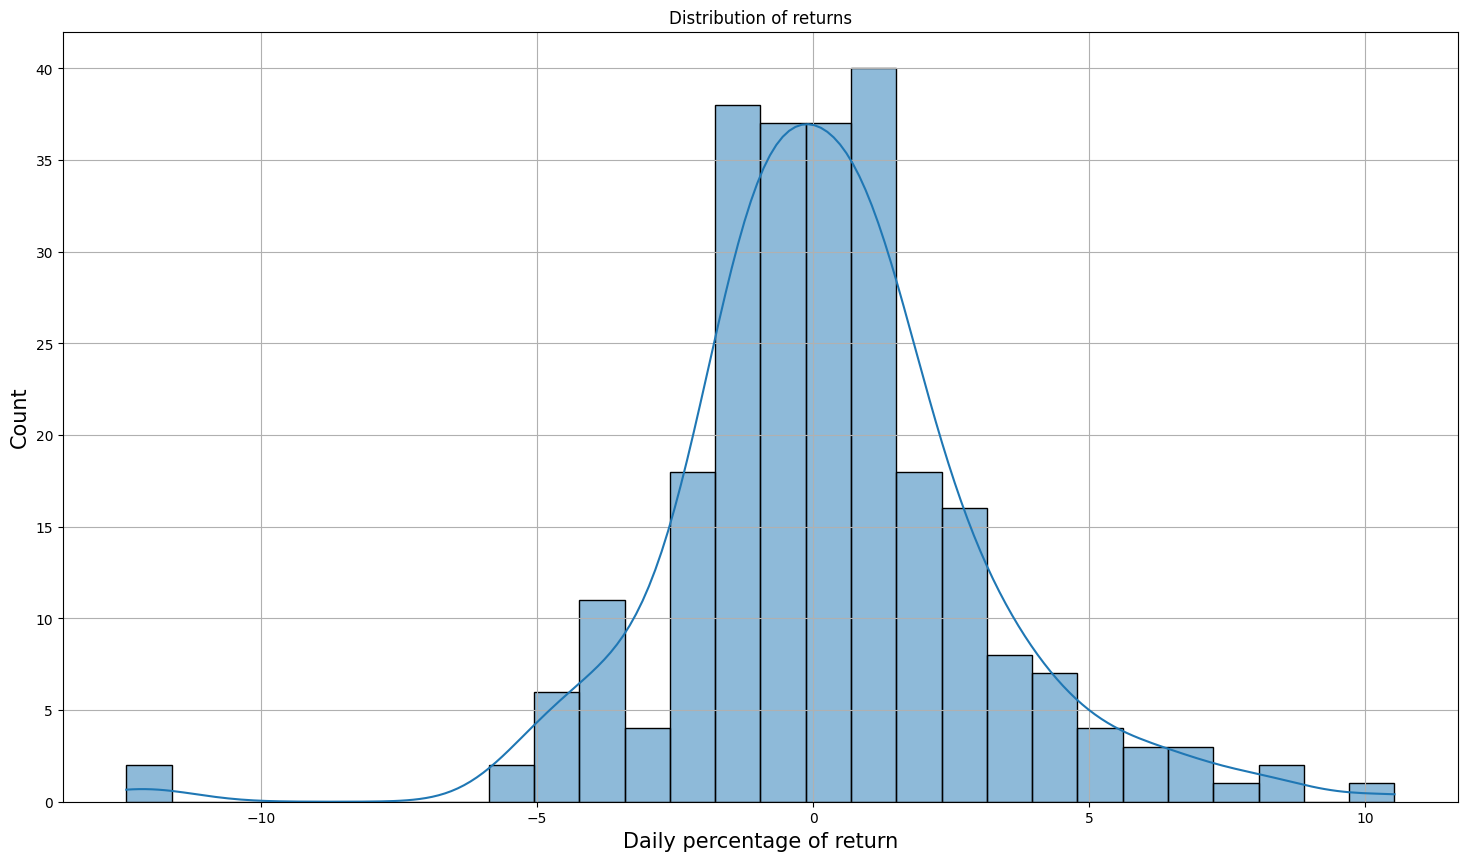

314.25404918263666


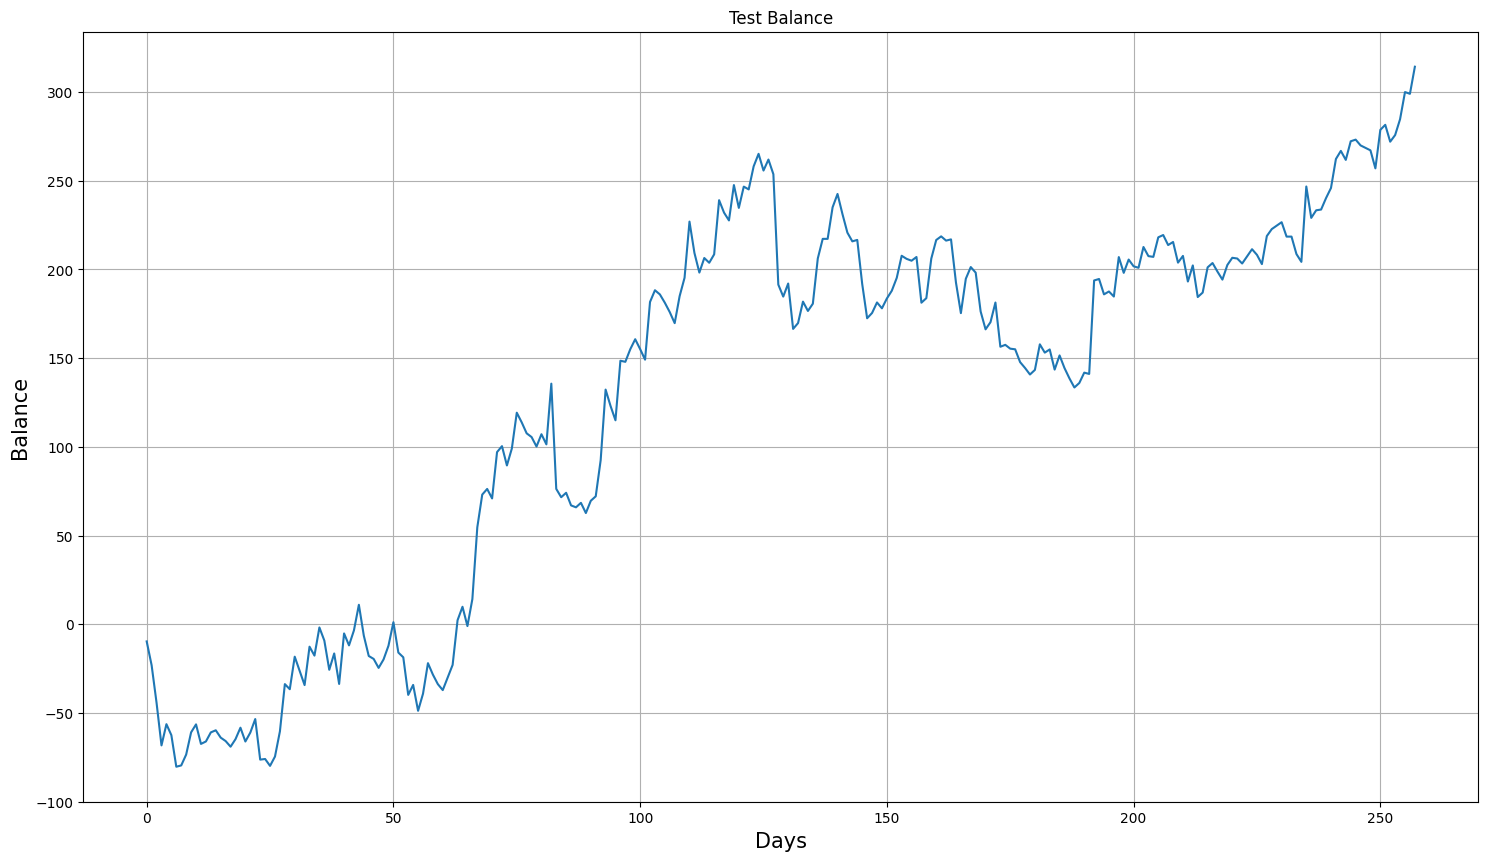

In [12]:
dtp=1

X_train, X_test, y_train, y_test, y_val = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=260)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

fs2 = Forecastsimulator(SVR(C=5))
pred = fs2.retrain(BaggingRegressor(SVR(C=0.01), 50), X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, retrain_period=20)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_val)
fs2.simulate(prediction, y_val)

# ARDRegression

c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


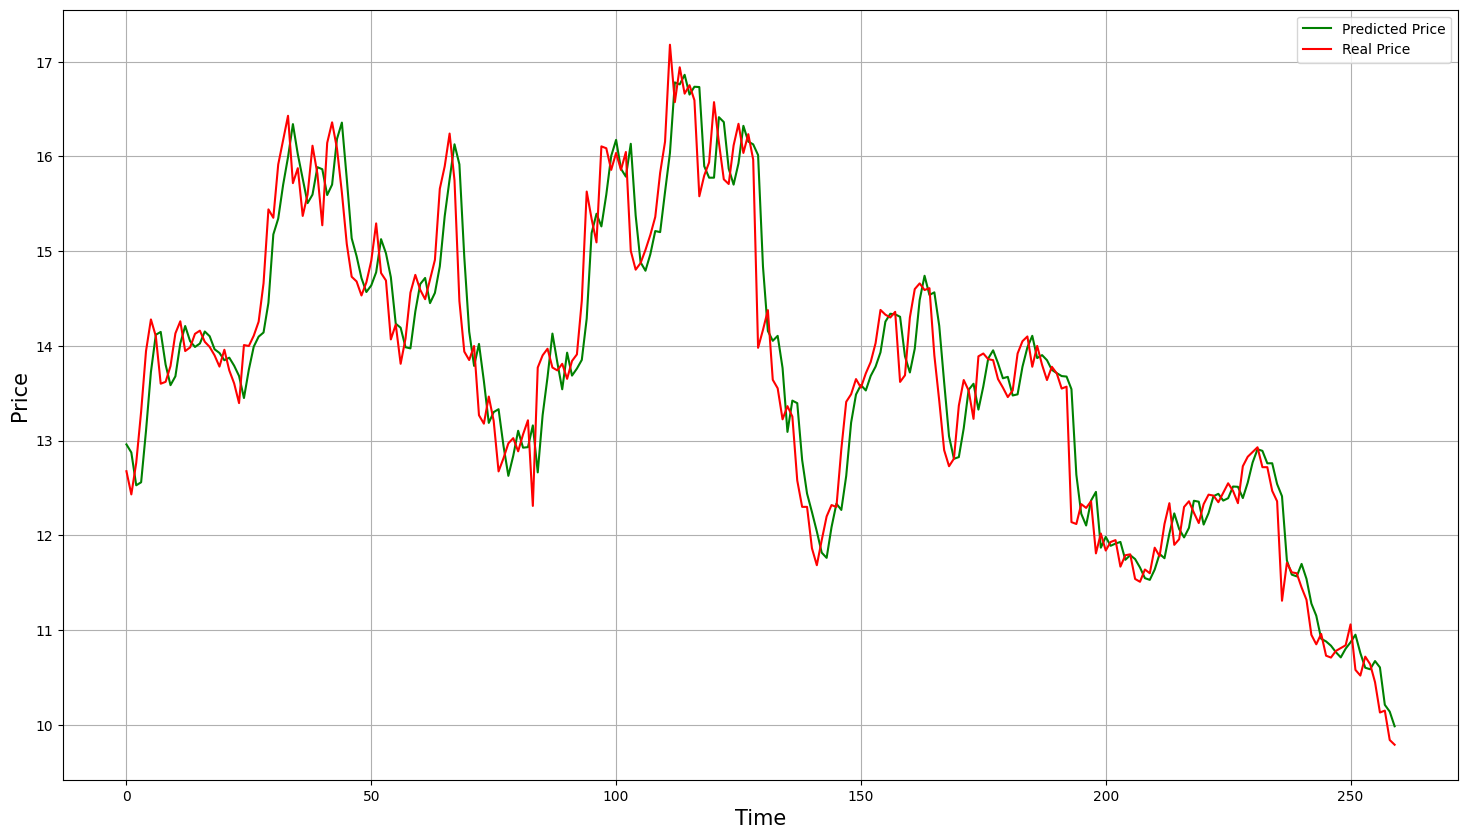

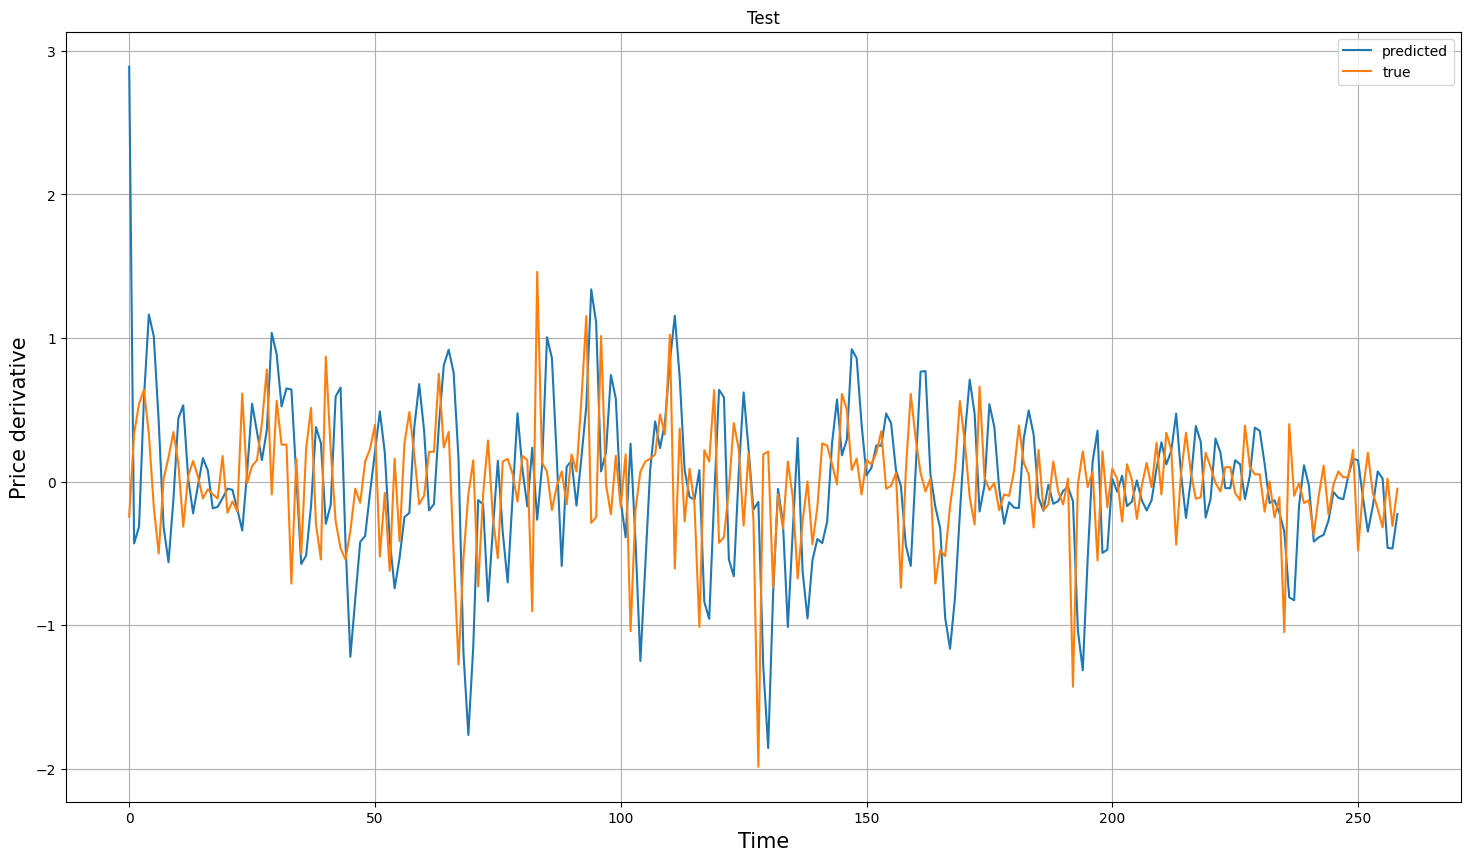

0.4806201550387597


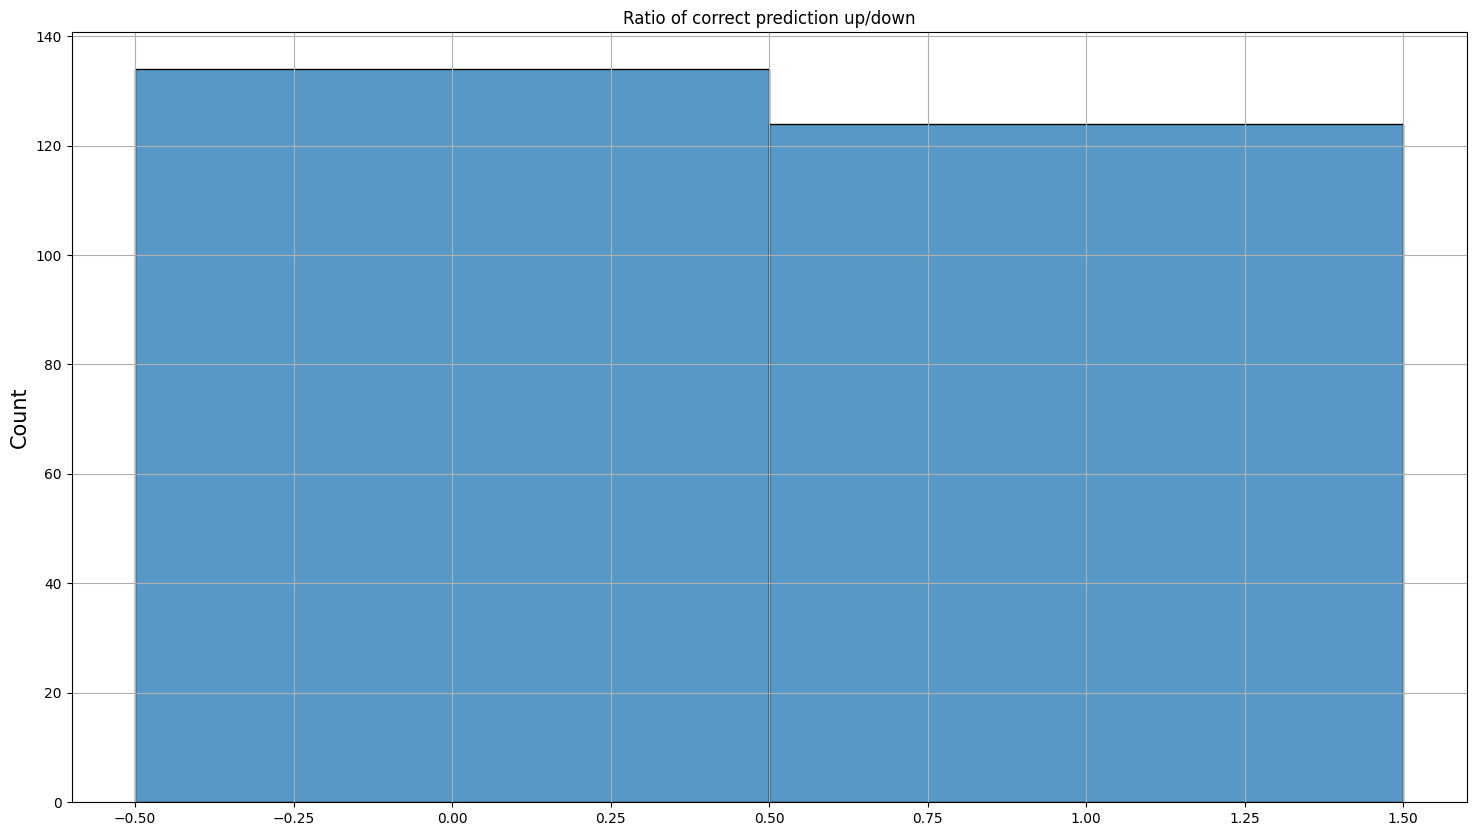

-0.01626130910463949 2.7492161439494107


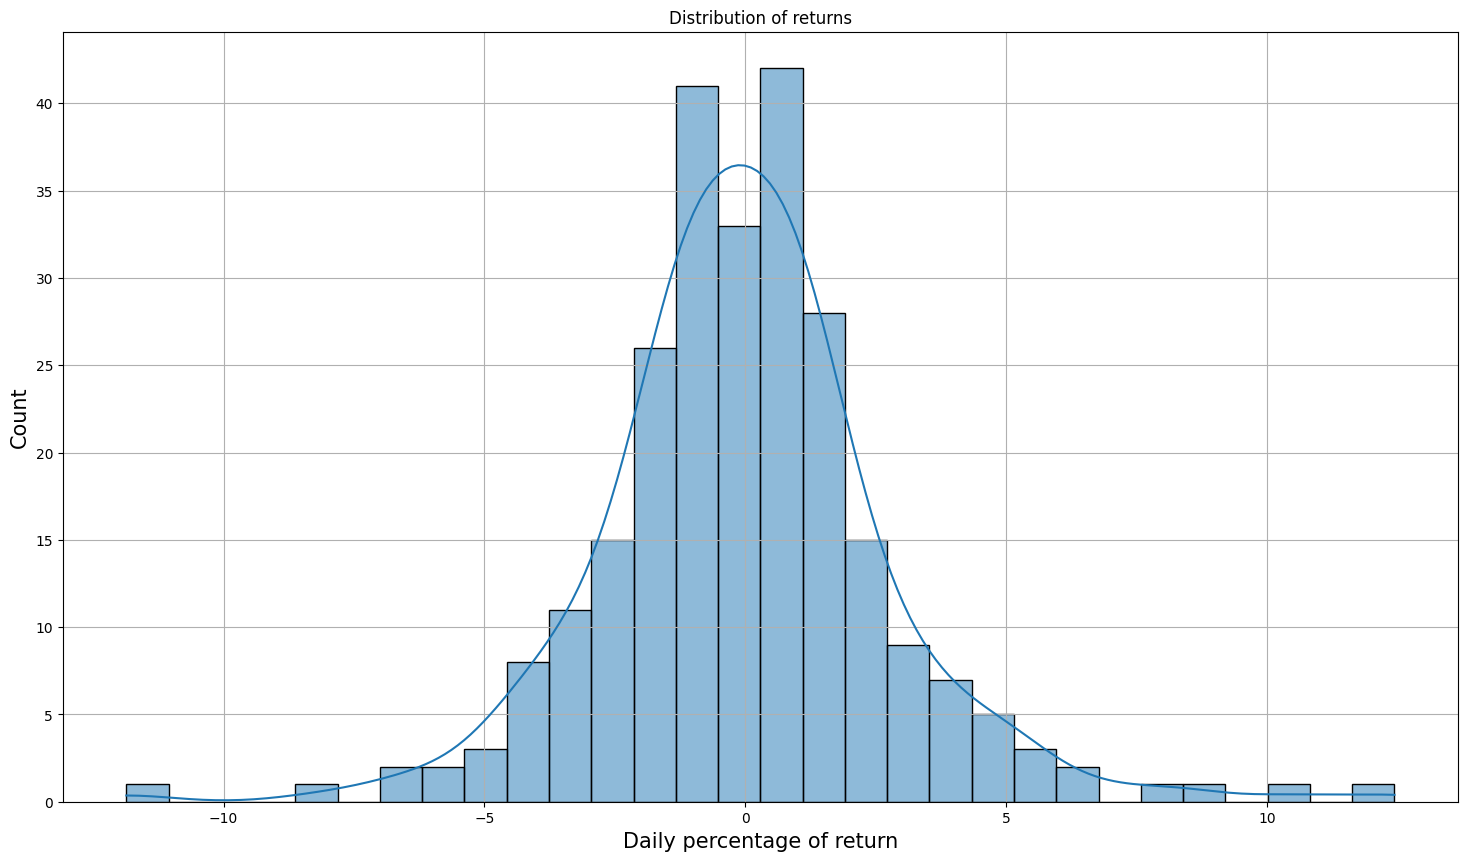

-20.97708874498494


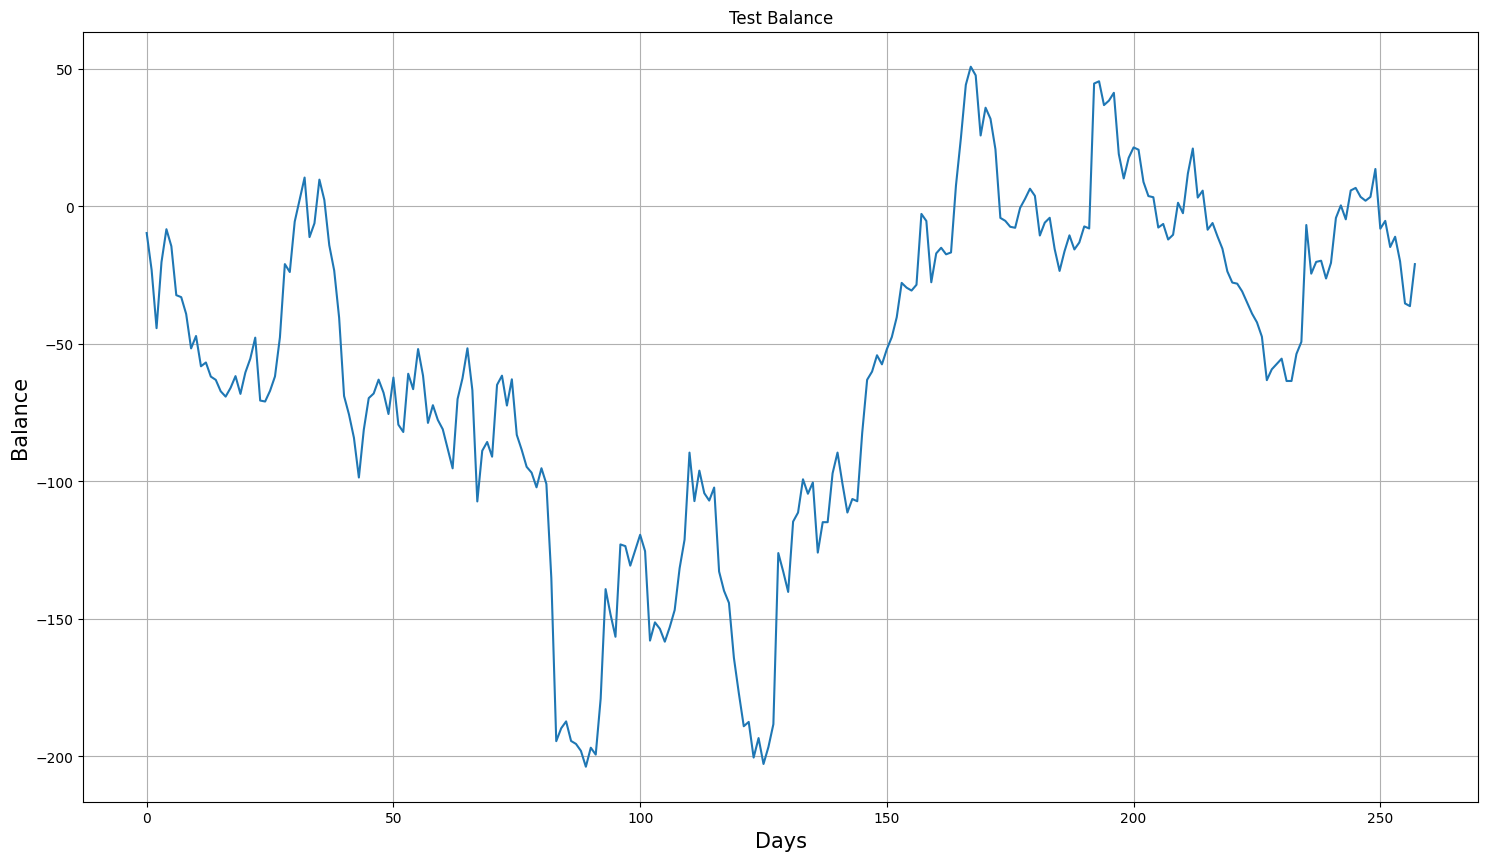

In [11]:
dtp=1

X_train, X_test, y_train, y_test, y_val = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=260)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

fs2 = Forecastsimulator(SVR(C=5))
pred = fs2.retrain(BaggingRegressor(ARDRegression(), 30), X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, retrain_period=20)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_val)
fs2.simulate(prediction, y_val)